In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna
!pip install shap
!pip install pytorch-tabnet
!pip install tabpfn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 341.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 

In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc, precision_score, recall_score, accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

from sklearn.linear_model import Lasso

from tabpfn import TabPFNClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import PartialDependenceDisplay

import pickle

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/TQP-atSDH/final_data.csv', index_col = 0)

In [5]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Hospital Complication - Cardiac Arrest with CPR'] != 'Unknown']
data = data[data['Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)'] != 'Unknown']
data = data[data['Hospital Complication - Catheter-Related Blood Stream Infection'] != 'Unknown']
data = data[data['Hospital Complication - Deep Surgical Site Infection'] != 'Unknown']
data = data[data['Hospital Complication - Deep Vein Thrombosis (DVT)'] != 'Unknown']
data = data[data['Hospital Complication - Pulmonary Embolism'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Intubation'] != 'Unknown']
data = data[data['Hospital Complication - Acute Kidney Injury'] != 'Unknown']
data = data[data['Hospital Complication - Myocardial Infarction'] != 'Unknown']
data = data[data['Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Return to the OR'] != 'Unknown']
data = data[data['Hospital Complication - Severe Sepsis'] != 'Unknown']
data = data[data['Hospital Complication - Stroke  or  CVA'] != 'Unknown']
data = data[data['Hospital Complication - Unplanned Admission to the ICU'] != 'Unknown']
data = data[data['Hospital Complication - Ventilator-Associated Pneumonia (VAP)'] != 'Unknown']
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  111183
Number of patients after exclusion:  100241
Number of patients excluded with this criteria:  10942


In [6]:
#Define outcome of interest.

data.loc[data['Hospital Complication - Cardiac Arrest with CPR'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Catheter-Related Blood Stream Infection'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Deep Surgical Site Infection'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Deep Vein Thrombosis (DVT)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Pulmonary Embolism'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Intubation'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Acute Kidney Injury'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Myocardial Infarction'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Return to the OR'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Severe Sepsis'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Stroke  or  CVA'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Unplanned Admission to the ICU'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['Hospital Complication - Ventilator-Associated Pneumonia (VAP)'] == 'Yes', 'OUTCOME'] = 1
data.loc[data['OUTCOME'] != 1, 'OUTCOME'] = 0
data = data[data['OUTCOME'].notna()]

print(data['OUTCOME'].value_counts(normalize=False, dropna=False))
print(data['OUTCOME'].value_counts(normalize=True, dropna=False))

0.0    95538
1.0     4703
Name: OUTCOME, dtype: int64
0.0    0.953083
1.0    0.046917
Name: OUTCOME, dtype: float64


In [7]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [8]:
#Check data shapes.

print(y.shape)
print(x.shape)

(100241,)
(100241, 77)


In [9]:
#Split data into initial train set and test set in 90:10 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  90216
Number patients y_train dataset:  90216
Number patients x_test dataset:  10025
Number patients y_test dataset:  10025


In [10]:
#Split initial train set into final train set and validation set in 60:30 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 1/3, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  60144
Number patients train_y dataset:  60144
Number patients valid_x dataset:  30072
Number patients valid_y dataset:  30072


In [11]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 2785
Before resampling, counts of label '0': 57359 



In [12]:
#Apply RUS.

from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [13]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 2785
After resampling, counts of label '0': 2785 



In [14]:
x_test = x_test[0:1000]
y_test = y_test[0:1000]

In [15]:
#Define function for AUROC with 95% confidence intervals.

def auroc_ci(y_test, y_probs, positive=1, n_samples=1000, alpha=0.05):
    auroc_values = []
    for i in range(n_samples):
        y_test_bs, y_probs_bs = resample(y_test, y_probs)
        
        auroc = roc_auc_score(y_test_bs, y_probs_bs)
        auroc_values.append(auroc)
    
    mean_auroc = np.mean(auroc_values)
    std_auroc = np.std(auroc_values)
    
    lower_ci = mean_auroc - 1.96 * std_auroc
    upper_ci = mean_auroc + 1.96 * std_auroc
    
    return auroc, lower_ci, upper_ci

In [16]:
#Define z-value for other confidence intervals.

confidence = 0.95
z_value = st.norm.ppf((1 + confidence) / 2.0)

#Feature Selection

In [17]:
alpha = 0.025

lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
lasso.fit(train_x, train_y)

selected_features_idx = np.nonzero(lasso.coef_)[0]

selected_features = train_x.columns[selected_features_idx]
print("Selected features:", selected_features)

train_x = train_x[selected_features]
valid_x = valid_x[selected_features]
x_test = x_test[selected_features]

Selected features: Index(['Age', 'Weight', 'Height', 'Systolic Blood Pressure', 'Pulse Rate',
       'Respiratory Rate', 'Total GCS', 'Pupillary Response', 'Midline Shift',
       'Bleeding Size', 'Days from Incident to ED or Hospital Arrival',
       'Blood Transfusion', 'Drug Screen - Cocaine', 'ACS Verification Level'],
      dtype='object')


#TabPFN

No hyperparameter tuning is performed for TabPFN since the paper that introduced TabPFN claims no hyperparameter tuning is needed for it:


*We present TabPFN, a trained Transformer that can do supervised classification for small tabular datasets in less than a second, needs no hyperparameter tuning and is competitive with state-of-the-art classification methods.*

https://doi.org/10.48550/arXiv.2207.01848


In [18]:
#Fit TabPFN.

tabpfn = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

tabpfn_data = data.sample(frac=0.10, random_state=42)
tabpfn_x = tabpfn_data.drop(outcomes, axis = 1)
tabpfn_x = tabpfn_x[selected_features]
tabpfn_y = tabpfn_data['OUTCOME']
tabpfn_x_train, tabpfn_x_test, tabpfn_y_train, tabpfn_y_test = train_test_split(tabpfn_x, tabpfn_y, test_size = 0.1, random_state = 0)
tabpfn_train_x, tabpfn_valid_x, tabpfn_train_y, tabpfn_valid_y = train_test_split(tabpfn_x_train, tabpfn_y_train, test_size = 1/3, random_state = 0)
tabpfn_train_x, tabpfn_train_y = resampler.fit_resample(tabpfn_train_x, tabpfn_train_y)

tabpfn.fit(tabpfn_train_x, tabpfn_train_y, overwrite_warning = True)

We have to download the TabPFN, as there is no checkpoint at  /usr/local/lib/python3.10/dist-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=2)

In [19]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabpfn = tabpfn.predict_proba(tabpfn_valid_x.values)

calib_model_tabpfn = LogisticRegression()
calib_model_tabpfn.fit(calib_probs_tabpfn, tabpfn_valid_y)

LogisticRegression()

In [20]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabpfn = tabpfn.predict(tabpfn_x_test.values)

uncalibrated_probs_tabpfn = tabpfn.predict_proba(tabpfn_x_test.values)

probs_tabpfn = calib_model_tabpfn.predict_proba(uncalibrated_probs_tabpfn)
probs_tabpfn = probs_tabpfn[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [66]:
#Evaluate TabNet model.

tabpfn_precision = round(precision_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_precision_ci_length = z_value * np.sqrt((tabpfn_precision * (1 - tabpfn_precision)) / y_test.shape[0])
tabpfn_precision_ci_lower = round((tabpfn_precision - tabpfn_precision_ci_length), 3)
tabpfn_precision_ci_upper = round((tabpfn_precision + tabpfn_precision_ci_length), 3)
tabpfn_precision_str = str(tabpfn_precision) + ' (' + str(tabpfn_precision_ci_lower) + ' - ' + str(tabpfn_precision_ci_upper) + ')'

tabpfn_recall = round(recall_score(tabpfn_y_test, preds_tabpfn, average = 'weighted'), 3)
tabpfn_recall_ci_length = z_value * np.sqrt((tabpfn_recall * (1 - tabpfn_recall)) / y_test.shape[0])
tabpfn_recall_ci_lower = round((tabpfn_recall - tabpfn_recall_ci_length), 3)
tabpfn_recall_ci_upper = round((tabpfn_recall + tabpfn_recall_ci_length), 3)
tabpfn_recall_str = str(tabpfn_recall) + ' (' + str(tabpfn_recall_ci_lower) + ' - ' + str(tabpfn_recall_ci_upper) + ')'

tabpfn_auprc = round(average_precision_score(tabpfn_y_test, probs_tabpfn, average = 'weighted'), 3)
tabpfn_auprc_ci_length = z_value * np.sqrt((tabpfn_auprc * (1 - tabpfn_auprc)) / y_test.shape[0])
tabpfn_auprc_ci_lower = round((tabpfn_auprc - tabpfn_auprc_ci_length), 3)
tabpfn_auprc_ci_upper = round((tabpfn_auprc + tabpfn_auprc_ci_length), 3)
tabpfn_auprc_str = str(tabpfn_auprc) + ' (' + str(tabpfn_auprc_ci_lower) + ' - ' + str(tabpfn_auprc_ci_upper) + ')'

tabpfn_accuracy = round(balanced_accuracy_score(tabpfn_y_test, preds_tabpfn), 3)
tabpfn_accuracy_ci_length = z_value * np.sqrt((tabpfn_accuracy * (1 - tabpfn_accuracy)) / y_test.shape[0])
tabpfn_accuracy_ci_lower = round((tabpfn_accuracy - tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_ci_upper = round((tabpfn_accuracy + tabpfn_accuracy_ci_length), 3)
tabpfn_accuracy_str = str(tabpfn_accuracy) + ' (' + str(tabpfn_accuracy_ci_lower) + ' - ' + str(tabpfn_accuracy_ci_upper) + ')'

tabpfn_auroc, tabpfn_auroc_ci_lower, tabpfn_auroc_ci_upper = auroc_ci(tabpfn_y_test, probs_tabpfn)
tabpfn_auroc = round(tabpfn_auroc, 3)
tabpfn_auroc_ci_lower = round(tabpfn_auroc_ci_lower, 3)
tabpfn_auroc_ci_upper = round(tabpfn_auroc_ci_upper, 3)
tabpfn_auroc_str = str(tabpfn_auroc) + ' (' + str(tabpfn_auroc_ci_lower) + ' - ' + str(tabpfn_auroc_ci_upper) + ')'

tabpfn_brier = round(brier_score_loss(tabpfn_y_test, probs_tabpfn), 3)
tabpfn_brier_ci_length = z_value * np.sqrt((tabpfn_brier * (1 - tabpfn_brier)) / y_test.shape[0])
tabpfn_brier_ci_lower = round((tabpfn_brier - tabpfn_brier_ci_length), 3)
tabpfn_brier_ci_upper = round((tabpfn_brier + tabpfn_brier_ci_length), 3)
tabpfn_brier_str = str(tabpfn_brier) + ' (' + str(tabpfn_brier_ci_lower) + ' - ' + str(tabpfn_brier_ci_upper) + ')'

tabpfn_results = [tabpfn_precision_str, tabpfn_recall_str, tabpfn_auprc_str, tabpfn_accuracy_str, tabpfn_auroc_str, tabpfn_brier_str]

print("Precision: ", (tabpfn_precision_str))
print("Recall: ", (tabpfn_recall_str))
print('AUPRC: ', (tabpfn_auprc_str))
print('Accuracy: ', (tabpfn_accuracy_str))
print('AUROC: ', (tabpfn_auroc_str))
print('Brier Score: ', (tabpfn_brier_str))

Precision:  0.945 (0.931 - 0.959)
Recall:  0.706 (0.678 - 0.734)
AUPRC:  0.106 (0.087 - 0.125)
Accuracy:  0.71 (0.682 - 0.738)
AUROC:  0.8 (0.695 - 0.834)
Brier Score:  0.039 (0.027 - 0.051)


In [22]:
#Recalculate precision recall curve for plotting purposes.

tabpfn_precision_curve, tabpfn_recall_curve, _ = precision_recall_curve(tabpfn_y_test, probs_tabpfn)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# TabNet

In [23]:
# Hyperparameter tuning for TabNet.

def objective(trial):

    param = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 1, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "n_independent": trial.suggest_int("n_independent", 1, 5),
        "n_shared": trial.suggest_int("n_shared", 1, 5),
        "lambda_sparse": trial.suggest_loguniform("lambda_sparse", 1e-6, 1e-3),
        "optimizer_params": {"lr": trial.suggest_loguniform("lr", 1e-5, 1e-2)},
        "seed": 31,
    }

    tabnet_clf = TabNetClassifier(**param)

    tabnet_clf.fit(
        train_x.values,
        train_y.values,
        eval_set=[(valid_x.values, valid_y.values)],
        eval_metric=["auc"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    preds = tabnet_clf.predict_proba(valid_x.values)[:, 1]
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    tabnet_params = {}

    for key, value in trial.params.items():
        tabnet_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:36:38,680] A new study created in memory with name: no-name-f041c670-3501-43a8-bdaa-d300f527895f
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 3.02243 | val_0_auc: 0.57161 |  0:00:03s
epoch 1  | loss: 3.01514 | val_0_auc: 0.56311 |  0:00:07s
epoch 2  | loss: 3.05341 | val_0_auc: 0.54868 |  0:00:11s
epoch 3  | loss: 2.89581 | val_0_auc: 0.56835 |  0:00:14s
epoch 4  | loss: 2.89719 | val_0_auc: 0.56031 |  0:00:17s
epoch 5  | loss: 2.93938 | val_0_auc: 0.56889 |  0:00:21s
epoch 6  | loss: 2.94142 | val_0_auc: 0.55329 |  0:00:25s
epoch 7  | loss: 2.98096 | val_0_auc: 0.55748 |  0:00:29s
epoch 8  | loss: 2.85113 | val_0_auc: 0.5301  |  0:00:32s
epoch 9  | loss: 2.86336 | val_0_auc: 0.52332 |  0:00:36s
epoch 10 | loss: 2.97337 | val_0_auc: 0.53745 |  0:00:40s
epoch 11 | loss: 2.97383 | val_0_auc: 0.54954 |  0:00:44s
epoch 12 | loss: 2.98502 | val_0_auc: 0.53286 |  0:00:47s
epoch 13 | loss: 2.90569 | val_0_auc: 0.53322 |  0:00:50s
epoch 14 | loss: 2.9304  | val_0_auc: 0.51862 |  0:00:54s
epoch 15 | loss: 2.92419 | val_0_auc: 0.60453 |  0:00:58s
epoch 16 | loss: 2.9126  | val_0_auc: 0.53565 |  0:01:03s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:38:59,989] Trial 0 finished with value: 0.49929315990434375 and parameters: {'n_d': 24, 'n_a': 62, 'n_steps': 8, 'gamma': 1.9868700030924629, 'n_independent': 2, 'n_shared': 1, 'lambda_sparse': 0.0005310328735364063, 'lr': 1.6066288228880885e-05}. Best is trial 0 with value: 0.49929315990434375.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.89309 | val_0_auc: 0.45736 |  0:00:01s
epoch 1  | loss: 0.86729 | val_0_auc: 0.46003 |  0:00:03s
epoch 2  | loss: 0.83379 | val_0_auc: 0.43488 |  0:00:04s
epoch 3  | loss: 0.81068 | val_0_auc: 0.44236 |  0:00:05s
epoch 4  | loss: 0.78916 | val_0_auc: 0.44343 |  0:00:07s
epoch 5  | loss: 0.76715 | val_0_auc: 0.43739 |  0:00:08s
epoch 6  | loss: 0.74192 | val_0_auc: 0.43047 |  0:00:09s
epoch 7  | loss: 0.74363 | val_0_auc: 0.46044 |  0:00:10s
epoch 8  | loss: 0.74641 | val_0_auc: 0.46549 |  0:00:11s
epoch 9  | loss: 0.74164 | val_0_auc: 0.4711  |  0:00:12s
epoch 10 | loss: 0.73557 | val_0_auc: 0.48477 |  0:00:13s
epoch 11 | loss: 0.73159 | val_0_auc: 0.47958 |  0:00:15s
epoch 12 | loss: 0.73399 | val_0_auc: 0.48647 |  0:00:16s
epoch 13 | loss: 0.73012 | val_0_auc: 0.48893 |  0:00:18s
epoch 14 | loss: 0.7247  | val_0_auc: 0.4861  |  0:00:20s
epoch 15 | loss: 0.71975 | val_0_auc: 0.50443 |  0:00:21s
epoch 16 | loss: 0.71936 | val_0_auc: 0.50966 |  0:00:22s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:43:30,034] Trial 1 finished with value: 0.6351667124897531 and parameters: {'n_d': 12, 'n_a': 38, 'n_steps': 1, 'gamma': 1.3823932675263133, 'n_independent': 4, 'n_shared': 3, 'lambda_sparse': 1.354780454607063e-06, 'lr': 3.826995629452713e-05}. Best is trial 1 with value: 0.6351667124897531.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
Device used : cpu


epoch 0  | loss: 0.96    | val_0_auc: 0.52322 |  0:00:01s
epoch 1  | loss: 0.78169 | val_0_auc: 0.54486 |  0:00:02s
epoch 2  | loss: 0.71889 | val_0_auc: 0.5034  |  0:00:03s
epoch 3  | loss: 0.67993 | val_0_auc: 0.51594 |  0:00:05s
epoch 4  | loss: 0.65876 | val_0_auc: 0.51984 |  0:00:07s
epoch 5  | loss: 0.65406 | val_0_auc: 0.51869 |  0:00:09s
epoch 6  | loss: 0.64124 | val_0_auc: 0.51451 |  0:00:11s
epoch 7  | loss: 0.63381 | val_0_auc: 0.49758 |  0:00:12s
epoch 8  | loss: 0.63701 | val_0_auc: 0.49564 |  0:00:14s
epoch 9  | loss: 0.63097 | val_0_auc: 0.50551 |  0:00:15s
epoch 10 | loss: 0.62379 | val_0_auc: 0.53301 |  0:00:16s
epoch 11 | loss: 0.61848 | val_0_auc: 0.56823 |  0:00:18s
epoch 12 | loss: 0.6213  | val_0_auc: 0.5825  |  0:00:19s
epoch 13 | loss: 0.62248 | val_0_auc: 0.58558 |  0:00:20s
epoch 14 | loss: 0.611   | val_0_auc: 0.54395 |  0:00:22s
epoch 15 | loss: 0.61407 | val_0_auc: 0.55596 |  0:00:24s
epoch 16 | loss: 0.61337 | val_0_auc: 0.55352 |  0:00:26s
epoch 17 | los

Best weights from best epoch are automatically used!
[I 2023-05-19 13:47:14,564] Trial 2 finished with value: 0.6713963180517137 and parameters: {'n_d': 33, 'n_a': 11, 'n_steps': 3, 'gamma': 1.943630899917515, 'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 1.665931010323424e-05, 'lr': 0.0030058770242540936}. Best is trial 2 with value: 0.6713963180517137.


Number of finished trials: 3
Best trial:
  Value: 0.6713963180517137
  Params: 
    n_d: 33
    n_a: 11
    n_steps: 3
    gamma: 1.943630899917515
    n_independent: 2
    n_shared: 2
    lambda_sparse: 1.665931010323424e-05
    lr: 0.0030058770242540936


In [24]:
#See TabNet hyperparameters.

tabnet_params.pop('lr')

print(tabnet_params)

{'n_d': 33, 'n_a': 11, 'n_steps': 3, 'gamma': 1.943630899917515, 'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 1.665931010323424e-05}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [25]:
#Fit TabNet.

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(train_x.values, train_y.values)

Device used : cpu
No early stopping will be performed, last training weights will be used.


epoch 0  | loss: 1.15845 |  0:00:00s
epoch 1  | loss: 0.70595 |  0:00:01s
epoch 2  | loss: 0.64218 |  0:00:01s
epoch 3  | loss: 0.61817 |  0:00:02s
epoch 4  | loss: 0.6227  |  0:00:02s
epoch 5  | loss: 0.61305 |  0:00:03s
epoch 6  | loss: 0.60766 |  0:00:03s
epoch 7  | loss: 0.60171 |  0:00:04s
epoch 8  | loss: 0.60296 |  0:00:04s
epoch 9  | loss: 0.59945 |  0:00:05s
epoch 10 | loss: 0.59462 |  0:00:05s
epoch 11 | loss: 0.59586 |  0:00:06s
epoch 12 | loss: 0.58703 |  0:00:06s
epoch 13 | loss: 0.58778 |  0:00:07s
epoch 14 | loss: 0.58169 |  0:00:07s
epoch 15 | loss: 0.57843 |  0:00:07s
epoch 16 | loss: 0.58271 |  0:00:08s
epoch 17 | loss: 0.57312 |  0:00:08s
epoch 18 | loss: 0.57836 |  0:00:08s
epoch 19 | loss: 0.57242 |  0:00:09s
epoch 20 | loss: 0.57368 |  0:00:09s
epoch 21 | loss: 0.57469 |  0:00:09s
epoch 22 | loss: 0.57626 |  0:00:10s
epoch 23 | loss: 0.56986 |  0:00:10s
epoch 24 | loss: 0.57263 |  0:00:11s
epoch 25 | loss: 0.57107 |  0:00:11s
epoch 26 | loss: 0.57299 |  0:00:11s
e

In [26]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_tabnet = tabnet.predict_proba(valid_x.values)

calib_model_tabnet = LogisticRegression()
calib_model_tabnet.fit(calib_probs_tabnet, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [27]:
#Make predictions on the test set based on the trained TabNet model.

preds_tabnet = tabnet.predict(x_test.values)

uncalibrated_probs_tabnet = tabnet.predict_proba(x_test.values)

probs_tabnet = calib_model_tabnet.predict_proba(uncalibrated_probs_tabnet)
probs_tabnet = probs_tabnet[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [28]:
#Evaluate TabNet model.

tabnet_precision = round(precision_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_precision_ci_length = z_value * np.sqrt((tabnet_precision * (1 - tabnet_precision)) / y_test.shape[0])
tabnet_precision_ci_lower = round((tabnet_precision - tabnet_precision_ci_length), 3)
tabnet_precision_ci_upper = round((tabnet_precision + tabnet_precision_ci_length), 3)
tabnet_precision_str = str(tabnet_precision) + ' (' + str(tabnet_precision_ci_lower) + ' - ' + str(tabnet_precision_ci_upper) + ')'

tabnet_recall = round(recall_score(y_test, preds_tabnet, average = 'weighted'), 3)
tabnet_recall_ci_length = z_value * np.sqrt((tabnet_recall * (1 - tabnet_recall)) / y_test.shape[0])
tabnet_recall_ci_lower = round((tabnet_recall - tabnet_recall_ci_length), 3)
tabnet_recall_ci_upper = round((tabnet_recall + tabnet_recall_ci_length), 3)
tabnet_recall_str = str(tabnet_recall) + ' (' + str(tabnet_recall_ci_lower) + ' - ' + str(tabnet_recall_ci_upper) + ')'

tabnet_auprc = round(average_precision_score(y_test, probs_tabnet, average = 'weighted'), 3)
tabnet_auprc_ci_length = z_value * np.sqrt((tabnet_auprc * (1 - tabnet_auprc)) / y_test.shape[0])
tabnet_auprc_ci_lower = round((tabnet_auprc - tabnet_auprc_ci_length), 3)
tabnet_auprc_ci_upper = round((tabnet_auprc + tabnet_auprc_ci_length), 3)
tabnet_auprc_str = str(tabnet_auprc) + ' (' + str(tabnet_auprc_ci_lower) + ' - ' + str(tabnet_auprc_ci_upper) + ')'

tabnet_accuracy = round(balanced_accuracy_score(y_test, preds_tabnet), 3)
tabnet_accuracy_ci_length = z_value * np.sqrt((tabnet_accuracy * (1 - tabnet_accuracy)) / y_test.shape[0])
tabnet_accuracy_ci_lower = round((tabnet_accuracy - tabnet_accuracy_ci_length), 3)
tabnet_accuracy_ci_upper = round((tabnet_accuracy + tabnet_accuracy_ci_length), 3)
tabnet_accuracy_str = str(tabnet_accuracy) + ' (' + str(tabnet_accuracy_ci_lower) + ' - ' + str(tabnet_accuracy_ci_upper) + ')'

tabnet_auroc, tabnet_auroc_ci_lower, tabnet_auroc_ci_upper = auroc_ci(y_test, probs_tabnet)
tabnet_auroc = round(tabnet_auroc, 3)
tabnet_auroc_ci_lower = round(tabnet_auroc_ci_lower, 3)
tabnet_auroc_ci_upper = round(tabnet_auroc_ci_upper, 3)
tabnet_auroc_str = str(tabnet_auroc) + ' (' + str(tabnet_auroc_ci_lower) + ' - ' + str(tabnet_auroc_ci_upper) + ')'

tabnet_brier = round(brier_score_loss(y_test, probs_tabnet), 3)
tabnet_brier_ci_length = z_value * np.sqrt((tabnet_brier * (1 - tabnet_brier)) / y_test.shape[0])
tabnet_brier_ci_lower = round((tabnet_brier - tabnet_brier_ci_length), 3)
tabnet_brier_ci_upper = round((tabnet_brier + tabnet_brier_ci_length), 3)
tabnet_brier_str = str(tabnet_brier) + ' (' + str(tabnet_brier_ci_lower) + ' - ' + str(tabnet_brier_ci_upper) + ')'

tabnet_results = [tabnet_precision_str, tabnet_recall_str, tabnet_auprc_str, tabnet_accuracy_str, tabnet_auroc_str, tabnet_brier_str]

print("Precision: ", (tabnet_precision_str))
print("Recall: ", (tabnet_recall_str))
print('AUPRC: ', (tabnet_auprc_str))
print('Accuracy: ', (tabnet_accuracy_str))
print('AUROC: ', (tabnet_auroc_str))
print('Brier Score: ', (tabnet_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.921 (0.904 - 0.938)
Recall:  0.56 (0.529 - 0.591)
AUPRC:  0.093 (0.075 - 0.111)
Accuracy:  0.547 (0.516 - 0.578)
AUROC:  0.606 (0.531 - 0.722)
Brier Score:  0.042 (0.03 - 0.054)


In [29]:
#Recalculate precision recall curve for plotting purposes.

tabnet_precision_curve, tabnet_recall_curve, _ = precision_recall_curve(y_test, probs_tabnet)

# XGBoost

In [30]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:48:01,101] A new study created in memory with name: no-name-43efcbbf-ef9e-44e4-a4ac-119933b3024e
APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
_PyDriveImportHook.find_spec() not found; falling back to find_module()
_OpenCVImportHook.find_spec() not found; falling back to find_module()
_BokehImportHook.find_spec() not found; falling back to find_module()
_AltairImportHook.find_spec() not found; falling back to find_module()


[0]	validation-auc:0.72713
[1]	validation-auc:0.73581
[2]	validation-auc:0.73680
[3]	validation-auc:0.73419
[4]	validation-auc:0.73490
[5]	validation-auc:0.72883
[6]	validation-auc:0.72529
[7]	validation-auc:0.72331
[8]	validation-auc:0.71893
[9]	validation-auc:0.71943


[I 2023-05-19 13:48:01,641] Trial 0 finished with value: 0.6604815626634505 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6604815626634505.


[0]	validation-auc:0.49976
[1]	validation-auc:0.63539
[2]	validation-auc:0.69992
[3]	validation-auc:0.71060
[4]	validation-auc:0.72337
[5]	validation-auc:0.72394
[6]	validation-auc:0.72589
[7]	validation-auc:0.72719
[8]	validation-auc:0.73676
[9]	validation-auc:0.73780


[I 2023-05-19 13:48:02,012] Trial 1 finished with value: 0.6861710988477392 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6861710988477392.


[0]	validation-auc:0.50000
[1]	validation-auc:0.49976
[2]	validation-auc:0.63539
[3]	validation-auc:0.69335
[4]	validation-auc:0.70016
[5]	validation-auc:0.71097
[6]	validation-auc:0.71903
[7]	validation-auc:0.72344
[8]	validation-auc:0.72204
[9]	validation-auc:0.72391


[I 2023-05-19 13:48:02,299] Trial 2 finished with value: 0.6684236402568725 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6861710988477392.


[0]	validation-auc:0.71610
[1]	validation-auc:0.71585
[2]	validation-auc:0.71601
[3]	validation-auc:0.71597
[4]	validation-auc:0.71590
[5]	validation-auc:0.71621
[6]	validation-auc:0.71616
[7]	validation-auc:0.71635
[8]	validation-auc:0.71620
[9]	validation-auc:0.71590


[I 2023-05-19 13:48:02,691] Trial 3 finished with value: 0.6661259036135427 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6861710988477392.


[0]	validation-auc:0.72579
[1]	validation-auc:0.72596
[2]	validation-auc:0.72591
[3]	validation-auc:0.72575
[4]	validation-auc:0.72573
[5]	validation-auc:0.72592
[6]	validation-auc:0.72592
[7]	validation-auc:0.72572
[8]	validation-auc:0.72580
[9]	validation-auc:0.72566


[I 2023-05-19 13:48:03,042] Trial 4 finished with value: 0.6735793703958558 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6861710988477392.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.58908
[3]	validation-auc:0.58908
[4]	validation-auc:0.58908


[I 2023-05-19 13:48:03,145] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74487
[2]	validation-auc:0.74395
[3]	validation-auc:0.74571
[4]	validation-auc:0.74680
[5]	validation-auc:0.74804
[6]	validation-auc:0.74911
[7]	validation-auc:0.75031
[8]	validation-auc:0.74987
[9]	validation-auc:0.75090


[I 2023-05-19 13:48:03,474] Trial 6 finished with value: 0.6888111162250689 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6888111162250689.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000


[I 2023-05-19 13:48:03,619] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72576
[1]	validation-auc:0.72600
[2]	validation-auc:0.72585
[3]	validation-auc:0.72576
[4]	validation-auc:0.72574
[5]	validation-auc:0.72592
[6]	validation-auc:0.72592
[7]	validation-auc:0.72573
[8]	validation-auc:0.72580
[9]	validation-auc:0.72566


[I 2023-05-19 13:48:03,918] Trial 8 finished with value: 0.6735793703958558 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.012396727001275e-07, 'alpha': 4.813416353568083e-07, 'max_depth': 7, 'eta': 7.282914217164152e-06, 'gamma': 1.2485590633659993e-05, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.6888111162250689.


[0]	validation-auc:0.72659
[1]	validation-auc:0.72659
[2]	validation-auc:0.72659
[3]	validation-auc:0.72659
[4]	validation-auc:0.72659
[5]	validation-auc:0.72659
[6]	validation-auc:0.72659
[7]	validation-auc:0.72659
[8]	validation-auc:0.72659
[9]	validation-auc:0.72659


[I 2023-05-19 13:48:04,134] Trial 9 finished with value: 0.6737072193386591 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009931126321758296, 'alpha': 1.5117729868865979e-05, 'max_depth': 4, 'eta': 0.00026829123048597897, 'gamma': 5.2949738366436485e-05, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.6888111162250689.


[0]	validation-auc:0.66711
[1]	validation-auc:0.69229
[2]	validation-auc:0.70303
[3]	validation-auc:0.70790
[4]	validation-auc:0.72386


[I 2023-05-19 13:48:04,307] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74330
[2]	validation-auc:0.74358
[3]	validation-auc:0.74321
[4]	validation-auc:0.74291
[5]	validation-auc:0.74310
[6]	validation-auc:0.74356
[7]	validation-auc:0.74381
[8]	validation-auc:0.74341
[9]	validation-auc:0.74357


[I 2023-05-19 13:48:04,653] Trial 11 finished with value: 0.6882941507969419 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00014191449257580337, 'alpha': 2.439344570853458e-08, 'max_depth': 5, 'eta': 0.010657872856106384, 'gamma': 1.2024518784549119e-08, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.6888111162250689.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73538
[2]	validation-auc:0.73483
[3]	validation-auc:0.73588
[4]	validation-auc:0.73481
[5]	validation-auc:0.73538
[6]	validation-auc:0.73637
[7]	validation-auc:0.73626
[8]	validation-auc:0.73612
[9]	validation-auc:0.73610


[I 2023-05-19 13:48:04,932] Trial 12 finished with value: 0.6805449858657298 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011154701167636573, 'alpha': 1.1793062427104753e-08, 'max_depth': 4, 'eta': 0.019352794400993342, 'gamma': 2.0368476286273254e-08, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.6888111162250689.


[0]	validation-auc:0.70247
[1]	validation-auc:0.71607
[2]	validation-auc:0.71651
[3]	validation-auc:0.71967
[4]	validation-auc:0.72098


[I 2023-05-19 13:48:05,219] Trial 13 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74166
[2]	validation-auc:0.74246
[3]	validation-auc:0.74301
[4]	validation-auc:0.74286
[5]	validation-auc:0.74464
[6]	validation-auc:0.74470
[7]	validation-auc:0.74496
[8]	validation-auc:0.74411
[9]	validation-auc:0.74627


[I 2023-05-19 13:48:05,601] Trial 14 finished with value: 0.6912840438949724 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 4.2378758079968624e-05, 'alpha': 0.01154617725866963, 'max_depth': 6, 'eta': 0.022039070219034146, 'gamma': 1.9771263133189483e-07, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.6912840438949724.


[0]	validation-auc:0.73804
[1]	validation-auc:0.74265
[2]	validation-auc:0.74507
[3]	validation-auc:0.74563
[4]	validation-auc:0.74641
[5]	validation-auc:0.74825
[6]	validation-auc:0.74770
[7]	validation-auc:0.74876
[8]	validation-auc:0.75104
[9]	validation-auc:0.75166


[I 2023-05-19 13:48:06,003] Trial 15 finished with value: 0.6904407472049183 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.039192137754905744, 'alpha': 0.020651037738437492, 'max_depth': 6, 'eta': 0.09093414765441594, 'gamma': 2.771767017676928e-07, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.6912840438949724.


[0]	validation-auc:0.73806
[1]	validation-auc:0.73759
[2]	validation-auc:0.73730
[3]	validation-auc:0.74010
[4]	validation-auc:0.74020
[5]	validation-auc:0.74106
[6]	validation-auc:0.74082
[7]	validation-auc:0.74092
[8]	validation-auc:0.74132
[9]	validation-auc:0.74117


[I 2023-05-19 13:48:06,388] Trial 16 finished with value: 0.6855984368504704 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.006061212784316734, 'alpha': 0.10678385090923492, 'max_depth': 6, 'eta': 0.004032511630601651, 'gamma': 1.567774535774144e-07, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.6912840438949724.


[0]	validation-auc:0.70064
[1]	validation-auc:0.70671
[2]	validation-auc:0.70237
[3]	validation-auc:0.69633
[4]	validation-auc:0.69086


[I 2023-05-19 13:48:06,696] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74258
[2]	validation-auc:0.74521
[3]	validation-auc:0.74735
[4]	validation-auc:0.74787
[5]	validation-auc:0.74962
[6]	validation-auc:0.75111
[7]	validation-auc:0.75184
[8]	validation-auc:0.75297
[9]	validation-auc:0.75407


[I 2023-05-19 13:48:07,109] Trial 18 finished with value: 0.6923582281807424 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011495749632424287, 'alpha': 0.0015526295235782444, 'max_depth': 6, 'eta': 0.10479464941534286, 'gamma': 1.6398844299357268e-07, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.73741
[1]	validation-auc:0.73685
[2]	validation-auc:0.73654
[3]	validation-auc:0.73691
[4]	validation-auc:0.73631
[5]	validation-auc:0.73687
[6]	validation-auc:0.73700
[7]	validation-auc:0.73689
[8]	validation-auc:0.73668
[9]	validation-auc:0.73869


[I 2023-05-19 13:48:07,485] Trial 19 finished with value: 0.6849333691816707 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0008486359212877582, 'alpha': 0.0006511287727800156, 'max_depth': 6, 'eta': 0.0013473283385123035, 'gamma': 4.6756301614408813e-08, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.71714
[1]	validation-auc:0.72751
[2]	validation-auc:0.73147
[3]	validation-auc:0.73325
[4]	validation-auc:0.73475
[5]	validation-auc:0.73625
[6]	validation-auc:0.73713
[7]	validation-auc:0.73852
[8]	validation-auc:0.74034
[9]	validation-auc:0.74038


[I 2023-05-19 13:48:07,932] Trial 20 finished with value: 0.6822784149971619 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 7.931743110130133e-06, 'alpha': 0.0036036314187428537, 'max_depth': 8, 'eta': 0.06474260759700237, 'gamma': 0.0007972039741362804, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74262
[2]	validation-auc:0.74710
[3]	validation-auc:0.74771
[4]	validation-auc:0.74907
[5]	validation-auc:0.75000
[6]	validation-auc:0.75034
[7]	validation-auc:0.75177
[8]	validation-auc:0.75338
[9]	validation-auc:0.75306


[I 2023-05-19 13:48:08,304] Trial 21 finished with value: 0.6895154246584914 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0009593433019951033, 'alpha': 0.01329101380132275, 'max_depth': 6, 'eta': 0.12237552208035464, 'gamma': 1.875460229436892e-07, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.73868
[1]	validation-auc:0.74682
[2]	validation-auc:0.74674
[3]	validation-auc:0.74844
[4]	validation-auc:0.75079
[5]	validation-auc:0.75056
[6]	validation-auc:0.75177
[7]	validation-auc:0.75272
[8]	validation-auc:0.75261
[9]	validation-auc:0.75314


[I 2023-05-19 13:48:08,684] Trial 22 finished with value: 0.6904627726663518 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04086191334312538, 'alpha': 0.9816765679580386, 'max_depth': 6, 'eta': 0.12973561149522653, 'gamma': 4.790168860986461e-07, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.72659
[1]	validation-auc:0.72659
[2]	validation-auc:0.72659
[3]	validation-auc:0.72659
[4]	validation-auc:0.72659
[5]	validation-auc:0.72659


[I 2023-05-19 13:48:08,887] Trial 23 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71518
[1]	validation-auc:0.72998
[2]	validation-auc:0.73418
[3]	validation-auc:0.73683
[4]	validation-auc:0.73960
[5]	validation-auc:0.74222
[6]	validation-auc:0.74363
[7]	validation-auc:0.74432
[8]	validation-auc:0.74427
[9]	validation-auc:0.74459


[I 2023-05-19 13:48:09,321] Trial 24 finished with value: 0.6805530871848776 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.9312613778488442, 'alpha': 0.9738877531056775, 'max_depth': 8, 'eta': 0.18966985724856675, 'gamma': 6.601923415377976e-08, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.72578
[1]	validation-auc:0.73541
[2]	validation-auc:0.73767
[3]	validation-auc:0.73745
[4]	validation-auc:0.73843
[5]	validation-auc:0.73953
[6]	validation-auc:0.73916
[7]	validation-auc:0.73947


[I 2023-05-19 13:48:09,660] Trial 25 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.73797
[1]	validation-auc:0.73919
[2]	validation-auc:0.73746
[3]	validation-auc:0.73735
[4]	validation-auc:0.73538
[5]	validation-auc:0.73186
[6]	validation-auc:0.72657
[7]	validation-auc:0.72107
[8]	validation-auc:0.72224


[I 2023-05-19 13:48:09,966] Trial 26 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.69775
[1]	validation-auc:0.69775
[2]	validation-auc:0.70601
[3]	validation-auc:0.70601
[4]	validation-auc:0.70604
[5]	validation-auc:0.70560


[I 2023-05-19 13:48:10,142] Trial 27 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74567
[2]	validation-auc:0.74905
[3]	validation-auc:0.74885
[4]	validation-auc:0.74915
[5]	validation-auc:0.75035
[6]	validation-auc:0.75146
[7]	validation-auc:0.75084
[8]	validation-auc:0.75166
[9]	validation-auc:0.75248


[I 2023-05-19 13:48:10,492] Trial 28 finished with value: 0.6906860652753664 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002546077620613184, 'alpha': 0.06612720545578052, 'max_depth': 5, 'eta': 0.31676337929557963, 'gamma': 3.6846091413097615e-06, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.72580
[1]	validation-auc:0.73277
[2]	validation-auc:0.73587
[3]	validation-auc:0.73368
[4]	validation-auc:0.73279


[I 2023-05-19 13:48:10,745] Trial 29 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69775
[1]	validation-auc:0.70843
[2]	validation-auc:0.71387
[3]	validation-auc:0.71333
[4]	validation-auc:0.72764
[5]	validation-auc:0.73214


[I 2023-05-19 13:48:10,972] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73943
[1]	validation-auc:0.74322
[2]	validation-auc:0.74330
[3]	validation-auc:0.74443
[4]	validation-auc:0.74412
[5]	validation-auc:0.74499
[6]	validation-auc:0.74613
[7]	validation-auc:0.74698
[8]	validation-auc:0.74716
[9]	validation-auc:0.74767


[I 2023-05-19 13:48:11,309] Trial 31 finished with value: 0.6861855293224715 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0024119357959847634, 'alpha': 0.3388368018396318, 'max_depth': 5, 'eta': 0.0470361561396713, 'gamma': 5.652065352033047e-07, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.6923582281807424.


[0]	validation-auc:0.73806
[1]	validation-auc:0.74270
[2]	validation-auc:0.74635
[3]	validation-auc:0.74929
[4]	validation-auc:0.75068
[5]	validation-auc:0.75167
[6]	validation-auc:0.75119
[7]	validation-auc:0.75182
[8]	validation-auc:0.75275
[9]	validation-auc:0.75271


[I 2023-05-19 13:48:11,646] Trial 32 finished with value: 0.6950802714144448 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00023521533776457224, 'alpha': 0.06913550697688388, 'max_depth': 6, 'eta': 0.22977187935332197, 'gamma': 2.8026195506573547e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73710
[2]	validation-auc:0.73732
[3]	validation-auc:0.73464
[4]	validation-auc:0.74138
[5]	validation-auc:0.74553
[6]	validation-auc:0.74796
[7]	validation-auc:0.74730
[8]	validation-auc:0.74976
[9]	validation-auc:0.74976


[I 2023-05-19 13:48:11,884] Trial 33 finished with value: 0.6823082886115199 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000509858688121998, 'alpha': 0.0818040452643101, 'max_depth': 4, 'eta': 0.3268707542508002, 'gamma': 2.810523656777507e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74363
[2]	validation-auc:0.74416
[3]	validation-auc:0.74350
[4]	validation-auc:0.74378
[5]	validation-auc:0.74447
[6]	validation-auc:0.74487
[7]	validation-auc:0.74417
[8]	validation-auc:0.74419
[9]	validation-auc:0.74457


[I 2023-05-19 13:48:12,132] Trial 34 finished with value: 0.6856569182480695 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0002865203799030767, 'alpha': 0.03442669007609683, 'max_depth': 5, 'eta': 0.028201817378774988, 'gamma': 1.443626065332372e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.71714
[1]	validation-auc:0.72984
[2]	validation-auc:0.73542
[3]	validation-auc:0.73465
[4]	validation-auc:0.73457


[I 2023-05-19 13:48:12,331] Trial 35 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74361
[2]	validation-auc:0.74421
[3]	validation-auc:0.74346
[4]	validation-auc:0.74483
[5]	validation-auc:0.74490
[6]	validation-auc:0.74525
[7]	validation-auc:0.74504
[8]	validation-auc:0.74571
[9]	validation-auc:0.74615


[I 2023-05-19 13:48:12,584] Trial 36 finished with value: 0.6894880827063672 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.939065287633376e-05, 'alpha': 0.0010524653988565882, 'max_depth': 5, 'eta': 0.039111790209973865, 'gamma': 1.83626911707875e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72574
[1]	validation-auc:0.73548
[2]	validation-auc:0.74111
[3]	validation-auc:0.74324
[4]	validation-auc:0.74573
[5]	validation-auc:0.74811
[6]	validation-auc:0.74800
[7]	validation-auc:0.74838
[8]	validation-auc:0.74798
[9]	validation-auc:0.74854


[I 2023-05-19 13:48:12,896] Trial 37 finished with value: 0.6882440238847142 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002217920068342239, 'alpha': 0.07563137963550709, 'max_depth': 7, 'eta': 0.15811923571091832, 'gamma': 1.873569799992949e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74309
[2]	validation-auc:0.74537
[3]	validation-auc:0.74791
[4]	validation-auc:0.74756
[5]	validation-auc:0.74659
[6]	validation-auc:0.74477
[7]	validation-auc:0.74408
[8]	validation-auc:0.74239
[9]	validation-auc:0.74082


[I 2023-05-19 13:48:13,161] Trial 38 finished with value: 0.6812925857233489 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0003518918557307958, 'alpha': 0.01792061031758091, 'max_depth': 6, 'eta': 0.4574004539884918, 'gamma': 1.4855229280926251e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74063
[2]	validation-auc:0.74359
[3]	validation-auc:0.74306
[4]	validation-auc:0.74285


[I 2023-05-19 13:48:13,315] Trial 39 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72469
[1]	validation-auc:0.73600
[2]	validation-auc:0.73820
[3]	validation-auc:0.74049
[4]	validation-auc:0.74055
[5]	validation-auc:0.74205


[I 2023-05-19 13:48:13,495] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73765
[1]	validation-auc:0.74475
[2]	validation-auc:0.74793
[3]	validation-auc:0.75038
[4]	validation-auc:0.75203
[5]	validation-auc:0.75364
[6]	validation-auc:0.75272
[7]	validation-auc:0.75244
[8]	validation-auc:0.75279
[9]	validation-auc:0.75385


[I 2023-05-19 13:48:13,747] Trial 41 finished with value: 0.6930351946620408 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02122215690061932, 'alpha': 0.4345326708179066, 'max_depth': 6, 'eta': 0.17870705269186038, 'gamma': 4.833085238137462e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73762
[1]	validation-auc:0.74525
[2]	validation-auc:0.74835
[3]	validation-auc:0.75061
[4]	validation-auc:0.75232
[5]	validation-auc:0.75287
[6]	validation-auc:0.75321
[7]	validation-auc:0.75251
[8]	validation-auc:0.75256
[9]	validation-auc:0.75303


[I 2023-05-19 13:48:14,004] Trial 42 finished with value: 0.6916731603802961 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.012385891022534724, 'alpha': 0.3203563924750268, 'max_depth': 6, 'eta': 0.18995232776312387, 'gamma': 1.0642250943743013e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73765
[1]	validation-auc:0.74161
[2]	validation-auc:0.74325
[3]	validation-auc:0.74358
[4]	validation-auc:0.74362
[5]	validation-auc:0.74497
[6]	validation-auc:0.74555
[7]	validation-auc:0.74478
[8]	validation-auc:0.74484
[9]	validation-auc:0.74589


[I 2023-05-19 13:48:14,266] Trial 43 finished with value: 0.6911663216011042 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.014886787883280425, 'alpha': 0.40088864799713547, 'max_depth': 6, 'eta': 0.027690442668681824, 'gamma': 1.0175666851727213e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72580
[1]	validation-auc:0.72890
[2]	validation-auc:0.72661
[3]	validation-auc:0.72223
[4]	validation-auc:0.71342


[I 2023-05-19 13:48:14,432] Trial 44 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73799
[1]	validation-auc:0.74262
[2]	validation-auc:0.74656
[3]	validation-auc:0.74641
[4]	validation-auc:0.74830
[5]	validation-auc:0.74991
[6]	validation-auc:0.75025
[7]	validation-auc:0.75179
[8]	validation-auc:0.75352
[9]	validation-auc:0.75383


[I 2023-05-19 13:48:14,683] Trial 45 finished with value: 0.6900744156796982 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.023780049073712516, 'alpha': 0.007784729046354564, 'max_depth': 6, 'eta': 0.11563343278725291, 'gamma': 2.7167217177079104e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72567
[1]	validation-auc:0.73511
[2]	validation-auc:0.73405
[3]	validation-auc:0.73535
[4]	validation-auc:0.73472
[5]	validation-auc:0.73595


[I 2023-05-19 13:48:14,868] Trial 46 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.58908
[1]	validation-auc:0.58908
[2]	validation-auc:0.59232
[3]	validation-auc:0.59232
[4]	validation-auc:0.59232


[I 2023-05-19 13:48:14,981] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74592
[2]	validation-auc:0.74911
[3]	validation-auc:0.75128
[4]	validation-auc:0.75218
[5]	validation-auc:0.75368
[6]	validation-auc:0.75365
[7]	validation-auc:0.75363
[8]	validation-auc:0.75357
[9]	validation-auc:0.75469


[I 2023-05-19 13:48:15,234] Trial 48 finished with value: 0.6946731801272616 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0012963552392473582, 'alpha': 0.007053314637197707, 'max_depth': 6, 'eta': 0.17808068659201898, 'gamma': 7.59885373218874e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74436
[2]	validation-auc:0.74909
[3]	validation-auc:0.74942
[4]	validation-auc:0.75100
[5]	validation-auc:0.75236
[6]	validation-auc:0.75264
[7]	validation-auc:0.75441
[8]	validation-auc:0.75512
[9]	validation-auc:0.75461


[I 2023-05-19 13:48:15,478] Trial 49 finished with value: 0.6912931578790139 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.01475468325116674, 'alpha': 8.102221135253825e-05, 'max_depth': 5, 'eta': 0.22737678538334516, 'gamma': 1.991430348774237e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72569
[1]	validation-auc:0.73508
[2]	validation-auc:0.73819
[3]	validation-auc:0.74097
[4]	validation-auc:0.73868
[5]	validation-auc:0.73871


[I 2023-05-19 13:48:15,662] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74568
[2]	validation-auc:0.74635
[3]	validation-auc:0.74899
[4]	validation-auc:0.75189
[5]	validation-auc:0.75167
[6]	validation-auc:0.75202
[7]	validation-auc:0.75335
[8]	validation-auc:0.75435
[9]	validation-auc:0.75370


[I 2023-05-19 13:48:15,922] Trial 51 finished with value: 0.6917698698776245 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004943581083660294, 'alpha': 5.247110748551184e-05, 'max_depth': 5, 'eta': 0.19680522035118167, 'gamma': 2.0579520766630736e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73681
[2]	validation-auc:0.73662
[3]	validation-auc:0.73795
[4]	validation-auc:0.73735


[I 2023-05-19 13:48:16,072] Trial 52 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74253
[2]	validation-auc:0.74491
[3]	validation-auc:0.74731
[4]	validation-auc:0.74706
[5]	validation-auc:0.74934
[6]	validation-auc:0.75017
[7]	validation-auc:0.75051
[8]	validation-auc:0.75129
[9]	validation-auc:0.75243


[I 2023-05-19 13:48:16,345] Trial 53 finished with value: 0.691178979912273 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0012628482224871006, 'alpha': 7.219795506520343e-06, 'max_depth': 6, 'eta': 0.10100145187892087, 'gamma': 7.116300582527016e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73741
[1]	validation-auc:0.73849
[2]	validation-auc:0.73333
[3]	validation-auc:0.73090
[4]	validation-auc:0.72572
[5]	validation-auc:0.72198


[I 2023-05-19 13:48:16,525] Trial 54 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74041
[1]	validation-auc:0.74358
[2]	validation-auc:0.74430
[3]	validation-auc:0.74480
[4]	validation-auc:0.74593
[5]	validation-auc:0.74713
[6]	validation-auc:0.74866
[7]	validation-auc:0.75057
[8]	validation-auc:0.75051
[9]	validation-auc:0.75078


[I 2023-05-19 13:48:16,795] Trial 55 finished with value: 0.6887321283633766 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.08105753257308804, 'alpha': 0.16009023758467175, 'max_depth': 5, 'eta': 0.06903142038078819, 'gamma': 3.392261421734979e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74294
[2]	validation-auc:0.74298
[3]	validation-auc:0.74640
[4]	validation-auc:0.74783
[5]	validation-auc:0.74875
[6]	validation-auc:0.74909
[7]	validation-auc:0.74745
[8]	validation-auc:0.74407
[9]	validation-auc:0.74390


[I 2023-05-19 13:48:17,086] Trial 56 finished with value: 0.680602960930882 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.011640973486136736, 'alpha': 0.00550820330033624, 'max_depth': 6, 'eta': 0.49724277057443345, 'gamma': 1.1514067673808267e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74571
[2]	validation-auc:0.74636
[3]	validation-auc:0.74900
[4]	validation-auc:0.75188
[5]	validation-auc:0.75172
[6]	validation-auc:0.75385
[7]	validation-auc:0.75394
[8]	validation-auc:0.75447
[9]	validation-auc:0.75460


[I 2023-05-19 13:48:17,355] Trial 57 finished with value: 0.6886371910296119 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02362997836096189, 'alpha': 0.0024497388895632697, 'max_depth': 5, 'eta': 0.193223259465141, 'gamma': 1.0252803728323415e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73433
[2]	validation-auc:0.73462
[3]	validation-auc:0.73511
[4]	validation-auc:0.73463


[I 2023-05-19 13:48:17,504] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.71817
[1]	validation-auc:0.71999
[2]	validation-auc:0.72863
[3]	validation-auc:0.72941
[4]	validation-auc:0.72895
[5]	validation-auc:0.72968


[I 2023-05-19 13:48:17,695] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73806
[1]	validation-auc:0.74286
[2]	validation-auc:0.74532
[3]	validation-auc:0.74546
[4]	validation-auc:0.74633
[5]	validation-auc:0.74778
[6]	validation-auc:0.74762
[7]	validation-auc:0.74869
[8]	validation-auc:0.75044
[9]	validation-auc:0.75145


[I 2023-05-19 13:48:17,945] Trial 60 finished with value: 0.6905458111876179 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.003854538095262954, 'alpha': 0.09085390060215259, 'max_depth': 6, 'eta': 0.09136680297997704, 'gamma': 5.640214743422402e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74434
[2]	validation-auc:0.74923
[3]	validation-auc:0.74941
[4]	validation-auc:0.75107
[5]	validation-auc:0.75240
[6]	validation-auc:0.75304
[7]	validation-auc:0.75477
[8]	validation-auc:0.75630
[9]	validation-auc:0.75638


[I 2023-05-19 13:48:18,187] Trial 61 finished with value: 0.6919263266036688 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.008994784927188705, 'alpha': 9.318605578531742e-05, 'max_depth': 5, 'eta': 0.23651958533398967, 'gamma': 1.9687565217564305e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74568
[2]	validation-auc:0.74632
[3]	validation-auc:0.74899
[4]	validation-auc:0.75190
[5]	validation-auc:0.75172
[6]	validation-auc:0.75384
[7]	validation-auc:0.75394
[8]	validation-auc:0.75446
[9]	validation-auc:0.75459


[I 2023-05-19 13:48:18,416] Trial 62 finished with value: 0.6886197225601991 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.007018494378022623, 'alpha': 4.039422778796253e-05, 'max_depth': 5, 'eta': 0.1930493848662435, 'gamma': 3.1198663774392734e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74331
[2]	validation-auc:0.74943
[3]	validation-auc:0.75140
[4]	validation-auc:0.75084
[5]	validation-auc:0.75160
[6]	validation-auc:0.75072
[7]	validation-auc:0.75047
[8]	validation-auc:0.75040
[9]	validation-auc:0.75006


[I 2023-05-19 13:48:18,681] Trial 63 finished with value: 0.6872316121574471 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0008556697870142476, 'alpha': 0.0005697296021241008, 'max_depth': 6, 'eta': 0.3167922372734188, 'gamma': 6.649617545365031e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74591
[2]	validation-auc:0.74776
[3]	validation-auc:0.74836
[4]	validation-auc:0.74775
[5]	validation-auc:0.74728
[6]	validation-auc:0.74622
[7]	validation-auc:0.74541
[8]	validation-auc:0.74350


[I 2023-05-19 13:48:18,902] Trial 64 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.73741
[1]	validation-auc:0.74189
[2]	validation-auc:0.74406
[3]	validation-auc:0.74511
[4]	validation-auc:0.74508


[I 2023-05-19 13:48:19,085] Trial 65 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72573
[1]	validation-auc:0.73573
[2]	validation-auc:0.74081
[3]	validation-auc:0.74091
[4]	validation-auc:0.74363
[5]	validation-auc:0.74676


[I 2023-05-19 13:48:19,270] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73732
[2]	validation-auc:0.74030
[3]	validation-auc:0.74487
[4]	validation-auc:0.74660
[5]	validation-auc:0.74873
[6]	validation-auc:0.75112
[7]	validation-auc:0.75304
[8]	validation-auc:0.75303
[9]	validation-auc:0.75228


[I 2023-05-19 13:48:19,518] Trial 67 finished with value: 0.689130611998965 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000581219626079075, 'alpha': 0.013668605849093175, 'max_depth': 4, 'eta': 0.4737913388457577, 'gamma': 1.4957560107176203e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.73809
[1]	validation-auc:0.74254
[2]	validation-auc:0.74670
[3]	validation-auc:0.74949
[4]	validation-auc:0.75177
[5]	validation-auc:0.75072
[6]	validation-auc:0.75152
[7]	validation-auc:0.75160
[8]	validation-auc:0.75104
[9]	validation-auc:0.75096


[I 2023-05-19 13:48:19,782] Trial 68 finished with value: 0.6912673349242299 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00022290654304293813, 'alpha': 0.1191458733481101, 'max_depth': 6, 'eta': 0.23826323045114872, 'gamma': 4.7596346361703314e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.6950802714144448.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74377
[2]	validation-auc:0.74410
[3]	validation-auc:0.74348
[4]	validation-auc:0.74480


[I 2023-05-19 13:48:19,929] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73836
[1]	validation-auc:0.74347
[2]	validation-auc:0.74553
[3]	validation-auc:0.74466
[4]	validation-auc:0.74477
[5]	validation-auc:0.74634


[I 2023-05-19 13:48:20,099] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74554
[2]	validation-auc:0.74927
[3]	validation-auc:0.74937
[4]	validation-auc:0.75174
[5]	validation-auc:0.75172
[6]	validation-auc:0.75310
[7]	validation-auc:0.75507
[8]	validation-auc:0.75441
[9]	validation-auc:0.75573


[I 2023-05-19 13:48:20,343] Trial 71 finished with value: 0.6956919210101129 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015632335156750454, 'alpha': 5.1559428771680384e-05, 'max_depth': 5, 'eta': 0.20969680356413398, 'gamma': 1.542577316341059e-08, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72659
[1]	validation-auc:0.73681
[2]	validation-auc:0.73668
[3]	validation-auc:0.73807
[4]	validation-auc:0.73941
[5]	validation-auc:0.73761


[I 2023-05-19 13:48:20,485] Trial 72 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74608
[2]	validation-auc:0.74602
[3]	validation-auc:0.74695
[4]	validation-auc:0.74882
[5]	validation-auc:0.74575
[6]	validation-auc:0.74358
[7]	validation-auc:0.74341
[8]	validation-auc:0.74029


[I 2023-05-19 13:48:20,700] Trial 73 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.73983
[1]	validation-auc:0.74433
[2]	validation-auc:0.74890
[3]	validation-auc:0.74786
[4]	validation-auc:0.74871
[5]	validation-auc:0.75104
[6]	validation-auc:0.75151
[7]	validation-auc:0.75216
[8]	validation-auc:0.75408
[9]	validation-auc:0.75377


[I 2023-05-19 13:48:20,963] Trial 74 finished with value: 0.6923944309506849 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.016015930937780216, 'alpha': 0.6452443026482951, 'max_depth': 5, 'eta': 0.3103399163354838, 'gamma': 1.252865293319068e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74565
[2]	validation-auc:0.74904
[3]	validation-auc:0.74886
[4]	validation-auc:0.74918
[5]	validation-auc:0.75031
[6]	validation-auc:0.75141
[7]	validation-auc:0.75079
[8]	validation-auc:0.75193
[9]	validation-auc:0.75309


[I 2023-05-19 13:48:21,229] Trial 75 finished with value: 0.6902230242528179 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.025438255394720007, 'alpha': 4.502708716570538e-05, 'max_depth': 5, 'eta': 0.3176206373547753, 'gamma': 3.8683416756992236e-08, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72660
[1]	validation-auc:0.73433
[2]	validation-auc:0.73402
[3]	validation-auc:0.73389
[4]	validation-auc:0.73409


[I 2023-05-19 13:48:21,380] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.69854
[1]	validation-auc:0.71824
[2]	validation-auc:0.73110
[3]	validation-auc:0.74072
[4]	validation-auc:0.74201
[5]	validation-auc:0.74514


[I 2023-05-19 13:48:21,531] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74047
[1]	validation-auc:0.74456
[2]	validation-auc:0.74404
[3]	validation-auc:0.74560
[4]	validation-auc:0.74634
[5]	validation-auc:0.74825
[6]	validation-auc:0.74964
[7]	validation-auc:0.75145
[8]	validation-auc:0.75155
[9]	validation-auc:0.75239


[I 2023-05-19 13:48:21,857] Trial 78 finished with value: 0.6894969435241852 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004293671681601311, 'alpha': 0.26369225958371606, 'max_depth': 5, 'eta': 0.08779796765459784, 'gamma': 2.765894148943236e-08, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73946
[1]	validation-auc:0.74342
[2]	validation-auc:0.74377
[3]	validation-auc:0.74334
[4]	validation-auc:0.74411


[I 2023-05-19 13:48:22,071] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74588
[2]	validation-auc:0.74709
[3]	validation-auc:0.74877
[4]	validation-auc:0.75157
[5]	validation-auc:0.75108
[6]	validation-auc:0.75305
[7]	validation-auc:0.75299
[8]	validation-auc:0.75331
[9]	validation-auc:0.75455


[I 2023-05-19 13:48:22,431] Trial 80 finished with value: 0.6909220161955496 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015815658272924495, 'alpha': 0.06191777306815727, 'max_depth': 5, 'eta': 0.34048204971811796, 'gamma': 1.897699948601407e-08, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73761
[1]	validation-auc:0.74559
[2]	validation-auc:0.74888
[3]	validation-auc:0.75016
[4]	validation-auc:0.75124
[5]	validation-auc:0.75132
[6]	validation-auc:0.75192
[7]	validation-auc:0.75249
[8]	validation-auc:0.75225
[9]	validation-auc:0.75195


[I 2023-05-19 13:48:22,793] Trial 81 finished with value: 0.693289373550307 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.010552377413184473, 'alpha': 0.2928558282940308, 'max_depth': 6, 'eta': 0.13982491096917593, 'gamma': 1.0612622741683263e-07, 'grow_policy': 'lossguide'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73818
[1]	validation-auc:0.74574
[2]	validation-auc:0.74879
[3]	validation-auc:0.75006
[4]	validation-auc:0.75119
[5]	validation-auc:0.75094
[6]	validation-auc:0.75126
[7]	validation-auc:0.75335
[8]	validation-auc:0.75378
[9]	validation-auc:0.75345


[I 2023-05-19 13:48:23,164] Trial 82 finished with value: 0.692397975277812 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.008693105459573866, 'alpha': 0.24317550073486013, 'max_depth': 6, 'eta': 0.12638075559914538, 'gamma': 1.1833633299440979e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73825
[1]	validation-auc:0.74339
[2]	validation-auc:0.74467
[3]	validation-auc:0.74518
[4]	validation-auc:0.74573


[I 2023-05-19 13:48:23,409] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72583
[1]	validation-auc:0.73618
[2]	validation-auc:0.74259
[3]	validation-auc:0.74214
[4]	validation-auc:0.74488
[5]	validation-auc:0.74708


[I 2023-05-19 13:48:23,665] Trial 84 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73862
[1]	validation-auc:0.74333
[2]	validation-auc:0.74825
[3]	validation-auc:0.74856
[4]	validation-auc:0.74940
[5]	validation-auc:0.75085
[6]	validation-auc:0.75151
[7]	validation-auc:0.75050
[8]	validation-auc:0.75014
[9]	validation-auc:0.74799


[I 2023-05-19 13:48:24,085] Trial 85 finished with value: 0.6864505943583425 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.03684424799130118, 'alpha': 0.9450411046298569, 'max_depth': 6, 'eta': 0.3789266827039142, 'gamma': 8.328763063608562e-08, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72633
[1]	validation-auc:0.73785
[2]	validation-auc:0.73969
[3]	validation-auc:0.74083
[4]	validation-auc:0.74057


[I 2023-05-19 13:48:24,358] Trial 86 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73809
[1]	validation-auc:0.74376
[2]	validation-auc:0.74418
[3]	validation-auc:0.74488
[4]	validation-auc:0.73954


[I 2023-05-19 13:48:24,595] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73863
[1]	validation-auc:0.74304
[2]	validation-auc:0.74719
[3]	validation-auc:0.74921
[4]	validation-auc:0.75058
[5]	validation-auc:0.75055
[6]	validation-auc:0.75115
[7]	validation-auc:0.75215
[8]	validation-auc:0.75246
[9]	validation-auc:0.75179


[I 2023-05-19 13:48:24,955] Trial 88 finished with value: 0.6918268322778833 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0027069716603692574, 'alpha': 0.2673401755688814, 'max_depth': 6, 'eta': 0.25218746915842116, 'gamma': 5.089637185976236e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73806
[1]	validation-auc:0.74278
[2]	validation-auc:0.74649
[3]	validation-auc:0.74792
[4]	validation-auc:0.74957
[5]	validation-auc:0.75089
[6]	validation-auc:0.75129
[7]	validation-auc:0.75168
[8]	validation-auc:0.75287
[9]	validation-auc:0.75279


[I 2023-05-19 13:48:25,347] Trial 89 finished with value: 0.690454671347204 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.05420681119798699, 'alpha': 0.0587305436668961, 'max_depth': 6, 'eta': 0.1297581156810705, 'gamma': 1.5151244687859588e-06, 'grow_policy': 'lossguide'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.74060
[1]	validation-auc:0.74366
[2]	validation-auc:0.74365
[3]	validation-auc:0.74329
[4]	validation-auc:0.74307


[I 2023-05-19 13:48:25,576] Trial 90 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73863
[1]	validation-auc:0.74304
[2]	validation-auc:0.74681
[3]	validation-auc:0.74876
[4]	validation-auc:0.74994
[5]	validation-auc:0.75024
[6]	validation-auc:0.75041
[7]	validation-auc:0.75127
[8]	validation-auc:0.75189
[9]	validation-auc:0.75274


[I 2023-05-19 13:48:25,969] Trial 91 finished with value: 0.6923113924294186 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.006395900301013031, 'alpha': 0.2646237604348063, 'max_depth': 6, 'eta': 0.23634024600761558, 'gamma': 5.748885994092966e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72737
[1]	validation-auc:0.73863
[2]	validation-auc:0.74051
[3]	validation-auc:0.74134
[4]	validation-auc:0.74293
[5]	validation-auc:0.74440


[I 2023-05-19 13:48:26,268] Trial 92 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73825
[1]	validation-auc:0.74493
[2]	validation-auc:0.74772
[3]	validation-auc:0.74921
[4]	validation-auc:0.74844
[5]	validation-auc:0.75030
[6]	validation-auc:0.74783
[7]	validation-auc:0.74824


[I 2023-05-19 13:48:26,588] Trial 93 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.73806
[1]	validation-auc:0.74452
[2]	validation-auc:0.74894
[3]	validation-auc:0.75051
[4]	validation-auc:0.75061
[5]	validation-auc:0.75247
[6]	validation-auc:0.75257
[7]	validation-auc:0.75305
[8]	validation-auc:0.75359
[9]	validation-auc:0.75353


[I 2023-05-19 13:48:26,959] Trial 94 finished with value: 0.6909083452194875 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.016957277927443424, 'alpha': 0.07983059308043343, 'max_depth': 6, 'eta': 0.1623960919452347, 'gamma': 8.702403508579224e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.73762
[1]	validation-auc:0.74212
[2]	validation-auc:0.74712
[3]	validation-auc:0.74917
[4]	validation-auc:0.75065
[5]	validation-auc:0.75051
[6]	validation-auc:0.75117
[7]	validation-auc:0.75196
[8]	validation-auc:0.75274
[9]	validation-auc:0.75282


[I 2023-05-19 13:48:27,337] Trial 95 finished with value: 0.6922412653855443 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002118973036392017, 'alpha': 0.3398456799858342, 'max_depth': 6, 'eta': 0.2574333065228372, 'gamma': 4.2806052090903413e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72633
[1]	validation-auc:0.72702
[2]	validation-auc:0.72471
[3]	validation-auc:0.72275
[4]	validation-auc:0.72064
[5]	validation-auc:0.71710


[I 2023-05-19 13:48:27,635] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73801
[1]	validation-auc:0.74286
[2]	validation-auc:0.74477
[3]	validation-auc:0.74395
[4]	validation-auc:0.74395
[5]	validation-auc:0.74571


[I 2023-05-19 13:48:27,915] Trial 97 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.73761
[1]	validation-auc:0.74204
[2]	validation-auc:0.74692
[3]	validation-auc:0.74945
[4]	validation-auc:0.75005
[5]	validation-auc:0.75068
[6]	validation-auc:0.75276
[7]	validation-auc:0.75274
[8]	validation-auc:0.75242
[9]	validation-auc:0.75329


[I 2023-05-19 13:48:28,335] Trial 98 finished with value: 0.6934473492736914 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0038919688127331473, 'alpha': 0.3050438879429756, 'max_depth': 6, 'eta': 0.2632153931602806, 'gamma': 3.9202097944772345e-07, 'grow_policy': 'depthwise'}. Best is trial 71 with value: 0.6956919210101129.


[0]	validation-auc:0.72569
[1]	validation-auc:0.73485
[2]	validation-auc:0.73824
[3]	validation-auc:0.73773
[4]	validation-auc:0.73642
[5]	validation-auc:0.73656


[I 2023-05-19 13:48:28,591] Trial 99 pruned. Trial was pruned at iteration 5.


Number of finished trials: 100
Best trial:
  Value: 0.6956919210101129
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.015632335156750454
    alpha: 5.1559428771680384e-05
    max_depth: 5
    eta: 0.20969680356413398
    gamma: 1.542577316341059e-08
    grow_policy: depthwise


In [31]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.015632335156750454, 'alpha': 5.1559428771680384e-05, 'max_depth': 5, 'eta': 0.20969680356413398, 'gamma': 1.542577316341059e-08, 'grow_policy': 'depthwise', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [32]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=5.1559428771680384e-05, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.20969680356413398,
              eval_metric='auc', feature_types=None,
              gamma=1.542577316341059e-08, gpu_id=None, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.015632335156750454, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [33]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_xgb = xgb.predict_proba(valid_x)

calib_model_xgb = LogisticRegression()
calib_model_xgb.fit(calib_probs_xgb, valid_y)

LogisticRegression()

In [34]:
#Make predictions on the test set based on the trained and calibrated XGBoost model.

preds_xgb = xgb.predict(x_test)

uncalibrated_probs_xgb = xgb.predict_proba(x_test)

probs_xgb = calib_model_xgb.predict_proba(uncalibrated_probs_xgb)
probs_xgb = probs_xgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [35]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_precision_ci_length = z_value * np.sqrt((xgb_precision * (1 - xgb_precision)) / y_test.shape[0])
xgb_precision_ci_lower = round((xgb_precision - xgb_precision_ci_length), 3)
xgb_precision_ci_upper = round((xgb_precision + xgb_precision_ci_length), 3)
xgb_precision_str = str(xgb_precision) + ' (' + str(xgb_precision_ci_lower) + ' - ' + str(xgb_precision_ci_upper) + ')'

xgb_recall = round(recall_score(y_test, preds_xgb, average = 'weighted'), 3)
xgb_recall_ci_length = z_value * np.sqrt((xgb_recall * (1 - xgb_recall)) / y_test.shape[0])
xgb_recall_ci_lower = round((xgb_recall - xgb_recall_ci_length), 3)
xgb_recall_ci_upper = round((xgb_recall + xgb_recall_ci_length), 3)
xgb_recall_str = str(xgb_recall) + ' (' + str(xgb_recall_ci_lower) + ' - ' + str(xgb_recall_ci_upper) + ')'

xgb_auprc = round(average_precision_score(y_test, probs_xgb, average = 'weighted'), 3)
xgb_auprc_ci_length = z_value * np.sqrt((xgb_auprc * (1 - xgb_auprc)) / y_test.shape[0])
xgb_auprc_ci_lower = round((xgb_auprc - xgb_auprc_ci_length), 3)
xgb_auprc_ci_upper = round((xgb_auprc + xgb_auprc_ci_length), 3)
xgb_auprc_str = str(xgb_auprc) + ' (' + str(xgb_auprc_ci_lower) + ' - ' + str(xgb_auprc_ci_upper) + ')'

xgb_accuracy = round(balanced_accuracy_score(y_test, preds_xgb), 3)
xgb_accuracy_ci_length = z_value * np.sqrt((xgb_accuracy * (1 - xgb_accuracy)) / y_test.shape[0])
xgb_accuracy_ci_lower = round((xgb_accuracy - xgb_accuracy_ci_length), 3)
xgb_accuracy_ci_upper = round((xgb_accuracy + xgb_accuracy_ci_length), 3)
xgb_accuracy_str = str(xgb_accuracy) + ' (' + str(xgb_accuracy_ci_lower) + ' - ' + str(xgb_accuracy_ci_upper) + ')'

xgb_auroc, xgb_auroc_ci_lower, xgb_auroc_ci_upper = auroc_ci(y_test, probs_xgb)
xgb_auroc = round(xgb_auroc, 3)
xgb_auroc_ci_lower = round(xgb_auroc_ci_lower, 3)
xgb_auroc_ci_upper = round(xgb_auroc_ci_upper, 3)
xgb_auroc_str = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_lower) + ' - ' + str(xgb_auroc_ci_upper) + ')'

xgb_brier = round(brier_score_loss(y_test, probs_xgb), 3)
xgb_brier_ci_length = z_value * np.sqrt((xgb_brier * (1 - xgb_brier)) / y_test.shape[0])
xgb_brier_ci_lower = round((xgb_brier - xgb_brier_ci_length), 3)
xgb_brier_ci_upper = round((xgb_brier + xgb_brier_ci_length), 3)
xgb_brier_str = str(xgb_brier) + ' (' + str(xgb_brier_ci_lower) + ' - ' + str(xgb_brier_ci_upper) + ')'

xgb_results = [xgb_precision_str, xgb_recall_str, xgb_auprc_str, xgb_accuracy_str, xgb_auroc_str, xgb_brier_str]

print("Precision: ", (xgb_precision_str))
print("Recall: ", (xgb_recall_str))
print('AUPRC: ', (xgb_auprc_str))
print('Accuracy: ', (xgb_accuracy_str))
print('AUROC: ', (xgb_auroc_str))
print('Brier Score: ', (xgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.932 (0.916 - 0.948)
Recall:  0.684 (0.655 - 0.713)
AUPRC:  0.091 (0.073 - 0.109)
Accuracy:  0.633 (0.603 - 0.663)
AUROC:  0.669 (0.555 - 0.716)
Brier Score:  0.043 (0.03 - 0.056)


In [36]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision_curve, xgb_recall_curve, _ = precision_recall_curve(y_test, probs_xgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# LightGBM

In [37]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:48:31,677] A new study created in memory with name: no-name-78eeb8d8-8b57-4fd0-95da-d8f098eb99b3
[I 2023-05-19 13:48:32,187] Trial 0 finished with value: 0.6824029727790613 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6824029727790613.
[I 2023-05-19 13:48:32,811] Trial 1 finished with value: 0.6696846612154915 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fra

Number of finished trials: 100
Best trial:
  Value: 0.696068379184268
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 8.727077988897811
    lambda_l2: 0.02959595169562026
    num_leaves: 233
    feature_fraction: 0.5650048842913007
    bagging_fraction: 0.40066234149130714
    bagging_freq: 1
    min_child_samples: 71


In [38]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 8.727077988897811, 'lambda_l2': 0.02959595169562026, 'num_leaves': 233, 'feature_fraction': 0.5650048842913007, 'bagging_fraction': 0.40066234149130714, 'bagging_freq': 1, 'min_child_samples': 71, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [39]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

[LightGBM] [Warning] lambda_l1 is set=8.727077988897811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.727077988897811
[LightGBM] [Warning] bagging_fraction is set=0.40066234149130714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40066234149130714
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5650048842913007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5650048842913007
[LightGBM] [Warning] lambda_l2 is set=0.02959595169562026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02959595169562026


LGBMClassifier(bagging_fraction=0.40066234149130714, bagging_freq=1,
               feature_fraction=0.5650048842913007, lambda_l1=8.727077988897811,
               lambda_l2=0.02959595169562026, metric='binary_logloss',
               min_child_samples=71, num_leaves=233, objective='binary',
               random_state=31, verbosity=-1)

In [40]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_lgb = lgb.predict_proba(valid_x)

calib_model_lgb = LogisticRegression()
calib_model_lgb.fit(calib_probs_lgb, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [41]:
#Make predictions on the test set based on the trained and calibrated LightGBM model.

preds_lgb = lgb.predict(x_test)

uncalibrated_probs_lgb = lgb.predict_proba(x_test)
uncalibrated_probs_lgb = uncalibrated_probs_lgb

probs_lgb = calib_model_xgb.predict_proba(uncalibrated_probs_lgb)
probs_lgb = probs_lgb[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [42]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_precision_ci_length = z_value * np.sqrt((lgb_precision * (1 - lgb_precision)) / y_test.shape[0])
lgb_precision_ci_lower = round((lgb_precision - lgb_precision_ci_length), 3)
lgb_precision_ci_upper = round((lgb_precision + lgb_precision_ci_length), 3)
lgb_precision_str = str(lgb_precision) + ' (' + str(lgb_precision_ci_lower) + ' - ' + str(lgb_precision_ci_upper) + ')'

lgb_recall = round(recall_score(y_test, preds_lgb, average = 'weighted'), 3)
lgb_recall_ci_length = z_value * np.sqrt((lgb_recall * (1 - lgb_recall)) / y_test.shape[0])
lgb_recall_ci_lower = round((lgb_recall - lgb_recall_ci_length), 3)
lgb_recall_ci_upper = round((lgb_recall + lgb_recall_ci_length), 3)
lgb_recall_str = str(lgb_recall) + ' (' + str(lgb_recall_ci_lower) + ' - ' + str(lgb_recall_ci_upper) + ')'

lgb_auprc = round(average_precision_score(y_test, probs_lgb, average = 'weighted'), 3)
lgb_auprc_ci_length = z_value * np.sqrt((lgb_auprc * (1 - lgb_auprc)) / y_test.shape[0])
lgb_auprc_ci_lower = round((lgb_auprc - lgb_auprc_ci_length), 3)
lgb_auprc_ci_upper = round((lgb_auprc + lgb_auprc_ci_length), 3)
lgb_auprc_str = str(lgb_auprc) + ' (' + str(lgb_auprc_ci_lower) + ' - ' + str(lgb_auprc_ci_upper) + ')'

lgb_accuracy = round(balanced_accuracy_score(y_test, preds_lgb), 3)
lgb_accuracy_ci_length = z_value * np.sqrt((lgb_accuracy * (1 - lgb_accuracy)) / y_test.shape[0])
lgb_accuracy_ci_lower = round((lgb_accuracy - lgb_accuracy_ci_length), 3)
lgb_accuracy_ci_upper = round((lgb_accuracy + lgb_accuracy_ci_length), 3)
lgb_accuracy_str = str(lgb_accuracy) + ' (' + str(lgb_accuracy_ci_lower) + ' - ' + str(lgb_accuracy_ci_upper) + ')'

lgb_auroc, lgb_auroc_ci_lower, lgb_auroc_ci_upper = auroc_ci(y_test, probs_lgb)
lgb_auroc = round(lgb_auroc, 3)
lgb_auroc_ci_lower = round(lgb_auroc_ci_lower, 3)
lgb_auroc_ci_upper = round(lgb_auroc_ci_upper, 3)
lgb_auroc_str = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_lower) + ' - ' + str(lgb_auroc_ci_upper) + ')'

lgb_brier = round(brier_score_loss(y_test, probs_lgb), 3)
lgb_brier_ci_length = z_value * np.sqrt((lgb_brier * (1 - lgb_brier)) / y_test.shape[0])
lgb_brier_ci_lower = round((lgb_brier - lgb_brier_ci_length), 3)
lgb_brier_ci_upper = round((lgb_brier + lgb_brier_ci_length), 3)
lgb_brier_str = str(lgb_brier) + ' (' + str(lgb_brier_ci_lower) + ' - ' + str(lgb_brier_ci_upper) + ')'

lgb_results = [lgb_precision_str, lgb_recall_str, lgb_auprc_str, lgb_accuracy_str, lgb_auroc_str, lgb_brier_str]

print("Precision: ", (lgb_precision_str))
print("Recall: ", (lgb_recall_str))
print('AUPRC: ', (lgb_auprc_str))
print('Accuracy: ', (lgb_accuracy_str))
print('AUROC: ', (lgb_auroc_str))
print('Brier Score: ', (lgb_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.933 (0.918 - 0.948)
Recall:  0.71 (0.682 - 0.738)
AUPRC:  0.092 (0.074 - 0.11)
Accuracy:  0.647 (0.617 - 0.677)
AUROC:  0.703 (0.595 - 0.76)
Brier Score:  0.042 (0.03 - 0.054)


In [43]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision_curve, lgb_recall_curve, _ = precision_recall_curve(y_test, probs_lgb)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Random Forest

In [44]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[I 2023-05-19 13:49:28,243] A new study created in memory with name: no-name-4ed114ba-c259-445e-b5ef-78a9425de2fc
[I 2023-05-19 13:49:33,157] Trial 0 finished with value: 0.6854824867201658 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.6854824867201658.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
[I 2023-05-19 13:49:38,287] Trial 1 finished with value: 0.6868179385484563 and parameters: {'criterion': 'entropy', '

Number of finished trials: 31
Best trial:
  Value: 0.6956496422508098
  Params: 
    criterion: gini
    max_features: log2
    max_depth: 71
    n_estimators: 1700
    min_samples_leaf: 4
    min_samples_split: 9


In [45]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'log2', 'max_depth': 71, 'n_estimators': 1700, 'min_samples_leaf': 4, 'min_samples_split': 9, 'random_state': 31}


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [46]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=71, max_features='log2', min_samples_leaf=4,
                       min_samples_split=9, n_estimators=1700, random_state=31)

In [47]:
#Predict on the validation set, get predicted probabilities for calibration, and fit calibration function.

calib_probs_rf = rf.predict_proba(valid_x)

calib_model_rf = LogisticRegression()
calib_model_rf.fit(calib_probs_rf, valid_y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


LogisticRegression()

In [48]:
#Make predictions on the test set based on the trained Random Forest model.

preds_rf = rf.predict(x_test)

uncalibrated_probs_rf = rf.predict_proba(x_test)

probs_rf = calib_model_rf.predict_proba(uncalibrated_probs_rf)
probs_rf = probs_rf[:, 1]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [49]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(y_test, preds_rf, average = 'weighted'), 3)
rf_precision_ci_length = z_value * np.sqrt((rf_precision * (1 - rf_precision)) / y_test.shape[0])
rf_precision_ci_lower = round((rf_precision - rf_precision_ci_length), 3)
rf_precision_ci_upper = round((rf_precision + rf_precision_ci_length), 3)
rf_precision_str = str(rf_precision) + ' (' + str(rf_precision_ci_lower) + ' - ' + str(rf_precision_ci_upper) + ')'

rf_recall = round(recall_score(y_test, preds_rf, average = 'weighted'), 3)
rf_recall_ci_length = z_value * np.sqrt((rf_recall * (1 - rf_recall)) / y_test.shape[0])
rf_recall_ci_lower = round((rf_recall - rf_recall_ci_length), 3)
rf_recall_ci_upper = round((rf_recall + rf_recall_ci_length), 3)
rf_recall_str = str(rf_recall) + ' (' + str(rf_recall_ci_lower) + ' - ' + str(rf_recall_ci_upper) + ')'

rf_auprc = round(average_precision_score(y_test, probs_rf, average = 'weighted'), 3)
rf_auprc_ci_length = z_value * np.sqrt((rf_auprc * (1 - rf_auprc)) / y_test.shape[0])
rf_auprc_ci_lower = round((rf_auprc - rf_auprc_ci_length), 3)
rf_auprc_ci_upper = round((rf_auprc + rf_auprc_ci_length), 3)
rf_auprc_str = str(rf_auprc) + ' (' + str(rf_auprc_ci_lower) + ' - ' + str(rf_auprc_ci_upper) + ')'

rf_accuracy = round(balanced_accuracy_score(y_test, preds_rf), 3)
rf_accuracy_ci_length = z_value * np.sqrt((rf_accuracy * (1 - rf_accuracy)) / y_test.shape[0])
rf_accuracy_ci_lower = round((rf_accuracy - rf_accuracy_ci_length), 3)
rf_accuracy_ci_upper = round((rf_accuracy + rf_accuracy_ci_length), 3)
rf_accuracy_str = str(rf_accuracy) + ' (' + str(rf_accuracy_ci_lower) + ' - ' + str(rf_accuracy_ci_upper) + ')'

rf_auroc, rf_auroc_ci_lower, rf_auroc_ci_upper = auroc_ci(y_test, probs_rf)
rf_auroc = round(rf_auroc, 3)
rf_auroc_ci_lower = round(rf_auroc_ci_lower, 3)
rf_auroc_ci_upper = round(rf_auroc_ci_upper, 3)
rf_auroc_str = str(rf_auroc) + ' (' + str(rf_auroc_ci_lower) + ' - ' + str(rf_auroc_ci_upper) + ')'

rf_brier = round(brier_score_loss(y_test, probs_rf), 3)
rf_brier_ci_length = z_value * np.sqrt((rf_brier * (1 - rf_brier)) / y_test.shape[0])
rf_brier_ci_lower = round((rf_brier - rf_brier_ci_length), 3)
rf_brier_ci_upper = round((rf_brier + rf_brier_ci_length), 3)
rf_brier_str = str(rf_brier) + ' (' + str(rf_brier_ci_lower) + ' - ' + str(rf_brier_ci_upper) + ')'

rf_results = [rf_precision_str, rf_recall_str, rf_auprc_str, rf_accuracy_str, rf_auroc_str, rf_brier_str]

print("Precision: ", (rf_precision_str))
print("Recall: ", (rf_recall_str))
print('AUPRC: ', (rf_auprc_str))
print('Accuracy: ', (rf_accuracy_str))
print('AUROC: ', (rf_auroc_str))
print('Brier Score: ', (rf_brier_str))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Precision:  0.932 (0.916 - 0.948)
Recall:  0.715 (0.687 - 0.743)
AUPRC:  0.105 (0.086 - 0.124)
Accuracy:  0.639 (0.609 - 0.669)
AUROC:  0.775 (0.618 - 0.773)
Brier Score:  0.042 (0.03 - 0.054)


In [50]:
#Recalculate precision recall curve for plotting purposes.

rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, probs_rf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# ROC and PR Curves

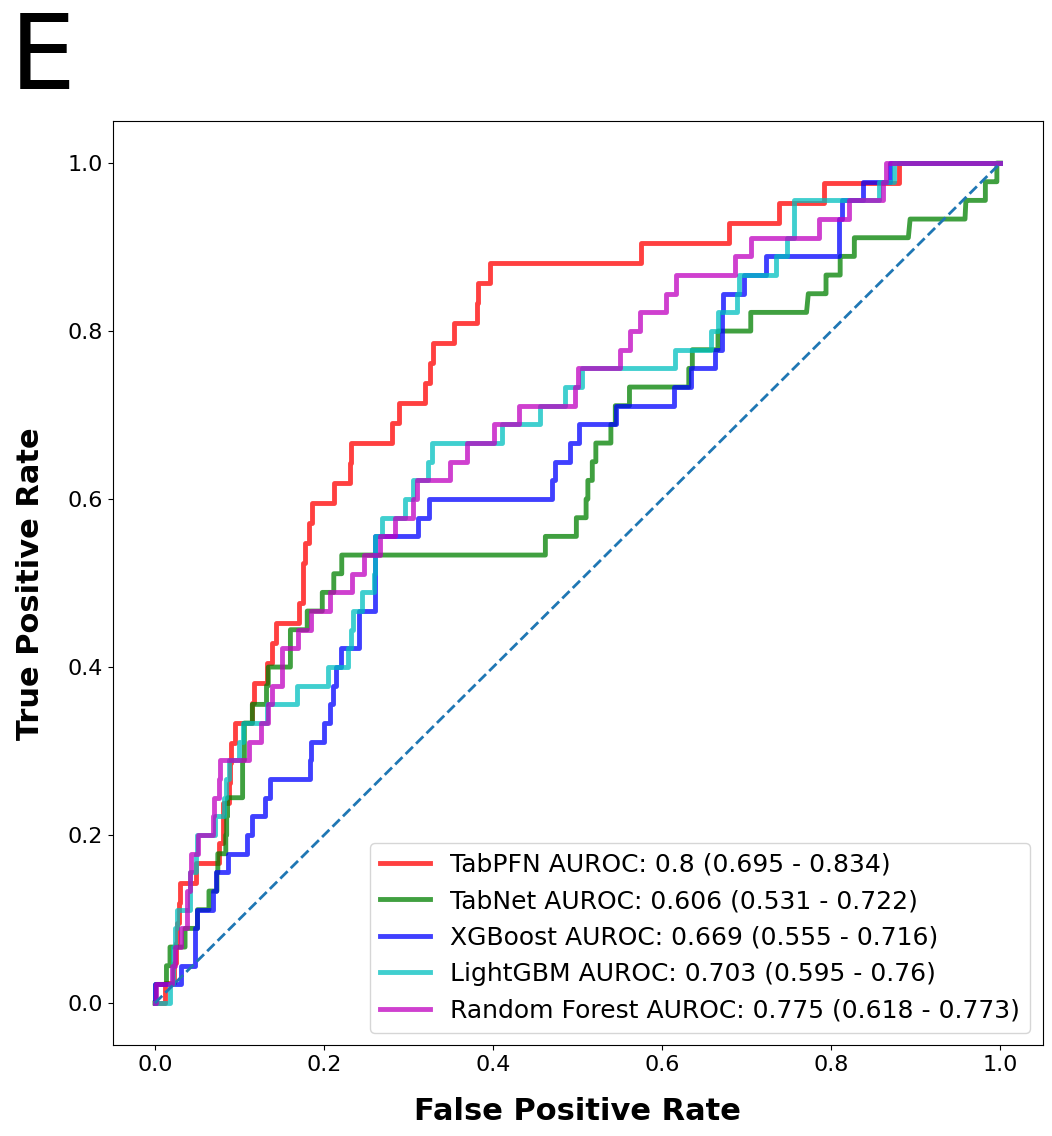

In [67]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_fpr, tabpfn_tpr, _ = roc_curve(tabpfn_y_test, probs_tabpfn)
tabpfn_label = 'TabPFN AUROC: ' + tabpfn_auroc_str
pyplot.plot(tabpfn_fpr, tabpfn_tpr, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)

tabnet_fpr, tabnet_tpr, _ = roc_curve(y_test, probs_tabnet)
tabnet_label = 'TabNet AUROC: ' + tabnet_auroc_str
pyplot.plot(tabnet_fpr, tabnet_tpr, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc_str
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc_str
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='c', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc_str
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('E', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_roc.png', dpi=300)
pyplot.show()

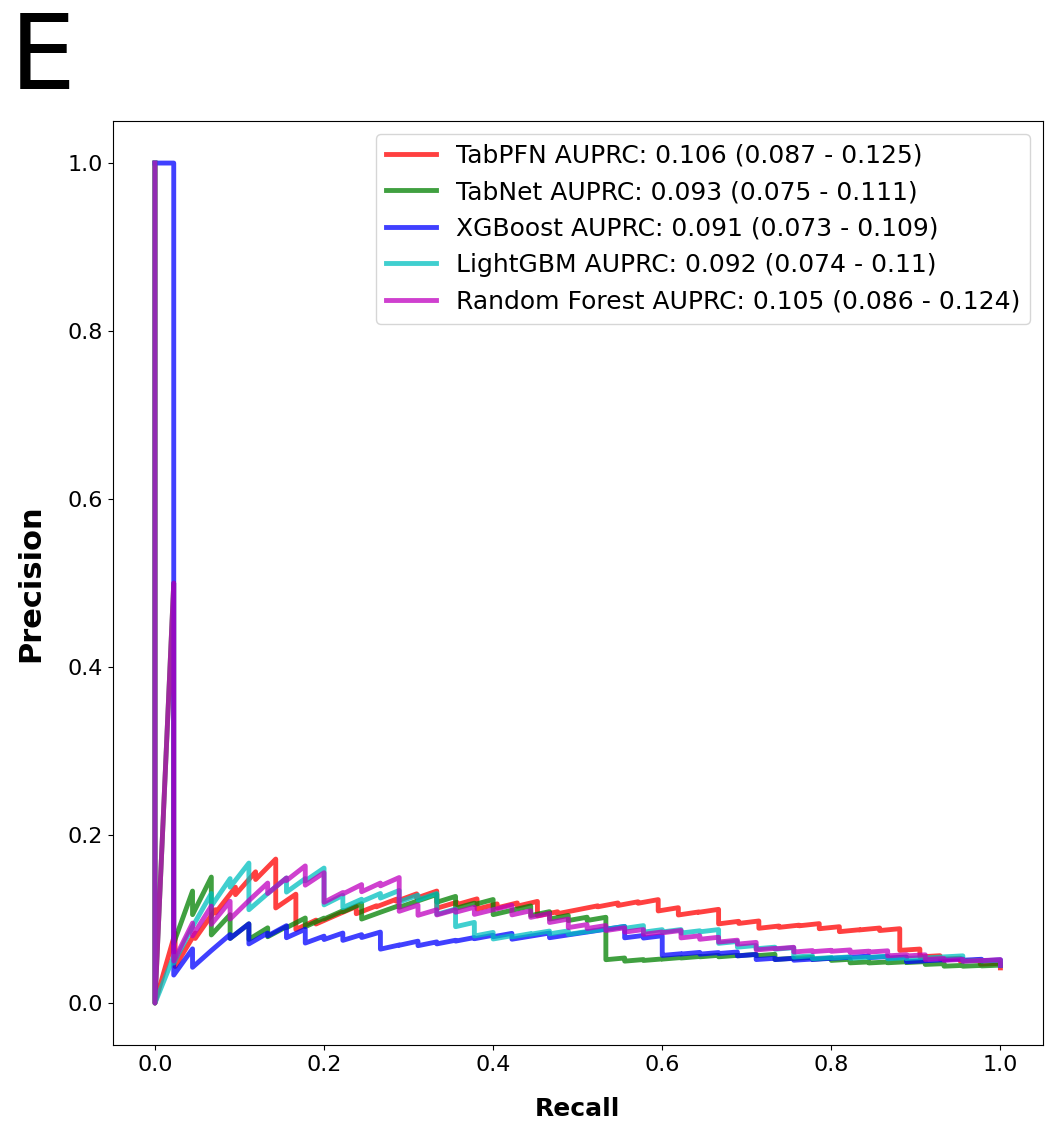

In [68]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

tabpfn_label = 'TabPFN AUPRC: ' + tabpfn_auprc_str
tabnet_label = 'TabNet AUPRC: ' + tabnet_auprc_str
xgb_label = 'XGBoost AUPRC: ' + xgb_auprc_str
lgb_label = 'LightGBM AUPRC: ' + lgb_auprc_str
rf_label = 'Random Forest AUPRC: ' + rf_auprc_str

pyplot.plot(tabpfn_recall_curve, tabpfn_precision_curve, label = tabpfn_label, color = 'r', linewidth = 3.5, alpha = 0.75)
pyplot.plot(tabnet_recall_curve, tabnet_precision_curve, label = tabnet_label, color = 'g', linewidth = 3.5, alpha = 0.75)
pyplot.plot(xgb_recall_curve, xgb_precision_curve, label = xgb_label, color = 'b', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall_curve, lgb_precision_curve, label = lgb_label, color = 'c', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall_curve, rf_precision_curve, label = rf_label, color = 'm', linewidth = 3.5, alpha = 0.75)

pyplot.title('E', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 18, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 18)

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [69]:
#Calculate means.

mean_precision = round((sum(list([tabpfn_precision, tabnet_precision, xgb_precision, lgb_precision, rf_precision]))/5), 3)
mean_precision_ci_lower = round((sum(list([tabpfn_precision_ci_lower, tabnet_precision_ci_lower, xgb_precision_ci_lower, lgb_precision_ci_lower, rf_precision_ci_lower]))/5), 3)
mean_precision_ci_upper = round((sum(list([tabpfn_precision_ci_upper, tabnet_precision_ci_upper, xgb_precision_ci_upper, lgb_precision_ci_upper, rf_precision_ci_upper]))/5), 3)
mean_precision_str = str(mean_precision) + ' (' + str(mean_precision_ci_lower) + ' - ' + str(mean_precision_ci_upper) + ')'

mean_recall = round((sum(list([tabpfn_recall, tabnet_recall, xgb_recall, lgb_recall, rf_recall]))/5), 3)
mean_recall_ci_lower = round((sum(list([tabpfn_recall_ci_lower, tabnet_recall_ci_lower, xgb_recall_ci_lower, lgb_recall_ci_lower, rf_recall_ci_lower]))/5), 3)
mean_recall_ci_upper = round((sum(list([tabpfn_recall_ci_upper, tabnet_recall_ci_upper, xgb_recall_ci_upper, lgb_recall_ci_upper, rf_recall_ci_upper]))/5), 3)
mean_recall_str = str(mean_recall) + ' (' + str(mean_recall_ci_lower) + ' - ' + str(mean_recall_ci_upper) + ')'

mean_auprc = round((sum(list([tabpfn_auprc, tabnet_auprc, xgb_auprc, lgb_auprc, rf_auprc]))/5), 3)
mean_auprc_ci_lower = round((sum(list([tabpfn_auprc_ci_lower, tabnet_auprc_ci_lower, xgb_auprc_ci_lower, lgb_auprc_ci_lower, rf_auprc_ci_lower]))/5), 3)
mean_auprc_ci_upper = round((sum(list([tabpfn_auprc_ci_upper, tabnet_auprc_ci_upper, xgb_auprc_ci_upper, lgb_auprc_ci_upper, rf_auprc_ci_upper]))/5), 3)
mean_auprc_str = str(mean_auprc) + ' (' + str(mean_auprc_ci_lower) + ' - ' + str(mean_auprc_ci_upper) + ')'

mean_accuracy = round((sum(list([tabpfn_accuracy, tabnet_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy]))/5), 3)
mean_accuracy_ci_lower = round((sum(list([tabpfn_accuracy_ci_lower, tabnet_accuracy_ci_lower, xgb_accuracy_ci_lower, lgb_accuracy_ci_lower, rf_accuracy_ci_lower]))/5), 3)
mean_accuracy_ci_upper = round((sum(list([tabpfn_accuracy_ci_upper, tabnet_accuracy_ci_upper, xgb_accuracy_ci_upper, lgb_accuracy_ci_upper, rf_accuracy_ci_upper]))/5), 3)
mean_accuracy_str = str(mean_accuracy) + ' (' + str(mean_accuracy_ci_lower) + ' - ' + str(mean_accuracy_ci_upper) + ')'

mean_auroc = round((sum(list([tabpfn_auroc, tabnet_auroc, xgb_auroc, lgb_auroc, rf_auroc]))/5), 3)
mean_auroc_ci_lower = round((sum(list([tabpfn_auroc_ci_lower, tabnet_auroc_ci_lower, xgb_auroc_ci_lower, lgb_auroc_ci_lower, rf_auroc_ci_lower]))/5), 3)
mean_auroc_ci_upper = round((sum(list([tabpfn_auroc_ci_upper, tabnet_auroc_ci_upper, xgb_auroc_ci_upper, lgb_auroc_ci_upper, rf_auroc_ci_upper]))/5), 3)
mean_auroc_str = str(mean_auroc) + ' (' + str(mean_auroc_ci_lower) + ' - ' + str(mean_auroc_ci_upper) + ')'

mean_brier = round((sum(list([tabpfn_brier, tabnet_brier, xgb_brier, lgb_brier, rf_brier]))/5), 3)
mean_brier_ci_lower = round((sum(list([tabpfn_brier_ci_lower, tabnet_brier_ci_lower, xgb_brier_ci_lower, lgb_brier_ci_lower, rf_brier_ci_lower]))/5), 3)
mean_brier_ci_upper = round((sum(list([tabpfn_brier_ci_upper, tabnet_brier_ci_upper, xgb_brier_ci_upper, lgb_brier_ci_upper, rf_brier_ci_upper]))/5), 3)
mean_brier_str = str(mean_brier) + ' (' + str(mean_brier_ci_lower) + ' - ' + str(mean_brier_ci_upper) + ')'

mean_results = [mean_precision_str, mean_recall_str, mean_auprc_str, mean_accuracy_str, mean_auroc_str, mean_brier_str]

In [70]:
results = {'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results}

results = pd.DataFrame(results, columns = ['TabPFN', 'TabNet', 'XGBoost', 'LightGBM', 'Random Forest', 'Mean'])

results

TabPFN                 TabNet                XGBoost  \
0  0.945 (0.931 - 0.959)  0.921 (0.904 - 0.938)  0.932 (0.916 - 0.948)   
1  0.706 (0.678 - 0.734)   0.56 (0.529 - 0.591)  0.684 (0.655 - 0.713)   
2  0.106 (0.087 - 0.125)  0.093 (0.075 - 0.111)  0.091 (0.073 - 0.109)   
3   0.71 (0.682 - 0.738)  0.547 (0.516 - 0.578)  0.633 (0.603 - 0.663)   
4    0.8 (0.695 - 0.834)  0.606 (0.531 - 0.722)  0.669 (0.555 - 0.716)   
5  0.039 (0.027 - 0.051)   0.042 (0.03 - 0.054)   0.043 (0.03 - 0.056)   

                LightGBM          Random Forest                   Mean  
0  0.933 (0.918 - 0.948)  0.932 (0.916 - 0.948)  0.933 (0.917 - 0.948)  
1   0.71 (0.682 - 0.738)  0.715 (0.687 - 0.743)  0.675 (0.646 - 0.704)  
2   0.092 (0.074 - 0.11)  0.105 (0.086 - 0.124)  0.097 (0.079 - 0.116)  
3  0.647 (0.617 - 0.677)  0.639 (0.609 - 0.669)  0.635 (0.605 - 0.665)  
4   0.703 (0.595 - 0.76)  0.775 (0.618 - 0.773)  0.711 (0.599 - 0.761)  
5   0.042 (0.03 - 0.054)   0.042 (0.03 - 0.054)  0.042 (0.029 - 0.054)

In [71]:
results = pd.DataFrame({'TabPFN':tabpfn_results, 'TabNet':tabnet_results, 'XGBoost':xgb_results, 'LightGBM':lgb_results, 'Random Forest':rf_results, 'Mean':mean_results})

results = results.T

results.columns = ['Weighted Precision (95% CI)', 'Weighted Recall (95% CI)',  'Weighted AUPRC (95% CI)', 'Balanced Accuracy (95% CI)', 'AUROC (95% CI)', 'Brier Score']

results.to_csv('/content/drive/MyDrive/TQP-atSDH/complications_results.csv')

results

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Weighted Precision (95% CI) Weighted Recall (95% CI)  \
TabPFN              0.945 (0.931 - 0.959)    0.706 (0.678 - 0.734)   
TabNet              0.921 (0.904 - 0.938)     0.56 (0.529 - 0.591)   
XGBoost             0.932 (0.916 - 0.948)    0.684 (0.655 - 0.713)   
LightGBM            0.933 (0.918 - 0.948)     0.71 (0.682 - 0.738)   
Random Forest       0.932 (0.916 - 0.948)    0.715 (0.687 - 0.743)   
Mean                0.933 (0.917 - 0.948)    0.675 (0.646 - 0.704)   

              Weighted AUPRC (95% CI) Balanced Accuracy (95% CI)  \
TabPFN          0.106 (0.087 - 0.125)       0.71 (0.682 - 0.738)   
TabNet          0.093 (0.075 - 0.111)      0.547 (0.516 - 0.578)   
XGBoost         0.091 (0.073 - 0.109)      0.633 (0.603 - 0.663)   
LightGBM         0.092 (0.074 - 0.11)      0.647 (0.617 - 0.677)   
Random Forest   0.105 (0.086 - 0.124)      0.639 (0.609 - 0.669)   
Mean            0.097 (0.079 - 0.116)      0.635 (0.605 - 0.665)   

                      AUROC (95% CI)            Brier Score  
TabPFN           0.8 (0.695 - 0.834)  0.039 (0.027 - 0.051)  
TabNet         0.606 (0.531 - 0.722)   0.042 (0.03 - 0.054)  
XGBoost        0.669 (0.555 - 0.716)   0.043 (0.03 - 0.056)  
LightGBM        0.703 (0.595 - 0.76)   0.042 (0.03 - 0.054)  
Random Forest  0.775 (0.618 - 0.773)   0.042 (0.03 - 0.054)  
Mean           0.711 (0.599 - 0.761)  0.042 (0.029 - 0.054)

# SHAP Plots

In [72]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [73]:
x_test = x_test[x_test['Age'] > 18]
x_test = x_test[x_test['Age'] < 90]

x_test = x_test[x_test['Weight'] > 30]
x_test = x_test[x_test['Weight'] < 250]

x_test = x_test[x_test['Height'] > 100]
x_test = x_test[x_test['Height'] < 220]

x_test = x_test[x_test['Systolic Blood Pressure'] > 50]
x_test = x_test[x_test['Systolic Blood Pressure'] < 250]

x_test = x_test[x_test['Pulse Rate'] > 20]
x_test = x_test[x_test['Pulse Rate'] < 220]

x_test = x_test[x_test['Respiratory Rate'] > 4]
x_test = x_test[x_test['Respiratory Rate'] < 50]

x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] > 0]
x_test = x_test[x_test['Days from Incident to ED or Hospital Arrival'] < 14]

In [74]:
x_test_sample = x_test.sample(frac=0.05, random_state=42)
tabpfn_x_test_sample = tabpfn_x_test.sample(frac=0.05, random_state=42)
tabnet_x_test_sample = x_test.sample(frac=0.05, random_state = 31)

feature_names = x_test_sample.columns

In [75]:
#Calculate SHAP values for TabPFN.

tabpfn_explainer = shap.Explainer(tabpfn.predict, tabpfn_x_test_sample)
tabpfn_shap_values = tabpfn_explainer(tabpfn_x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

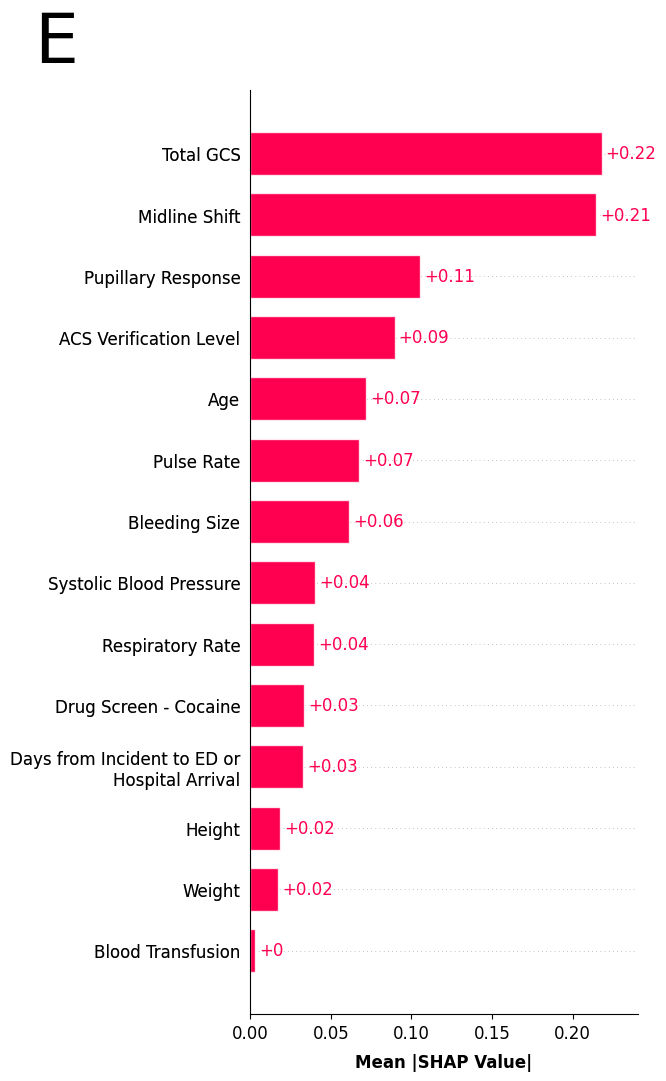

In [76]:
#Plot SHAP bar plot for TabPFN.

shap.plots.bar(tabpfn_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('E', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_shap_tabpfn.png', dpi=300, bbox_inches='tight')

In [77]:
#Calculate SHAP values for TabNet.

tabnet_explainer = shap.Explainer(tabnet.predict, x_test_sample.values, feature_names=feature_names)
tabnet_shap_values = tabnet_explainer(x_test_sample.values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

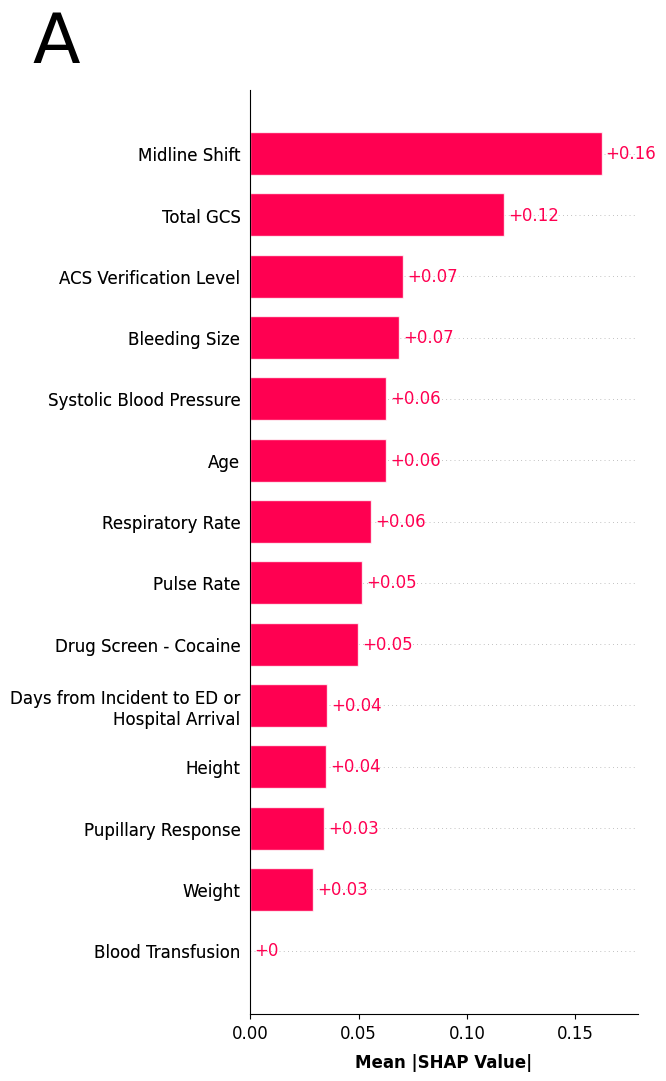

In [78]:
#Plot SHAP bar plot for TabNet.

shap.plots.bar(tabnet_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_shap_tabnet.png', dpi=300, bbox_inches='tight')

In [79]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test_sample)
xgb_shap_values = xgb_explainer(x_test_sample)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, y

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


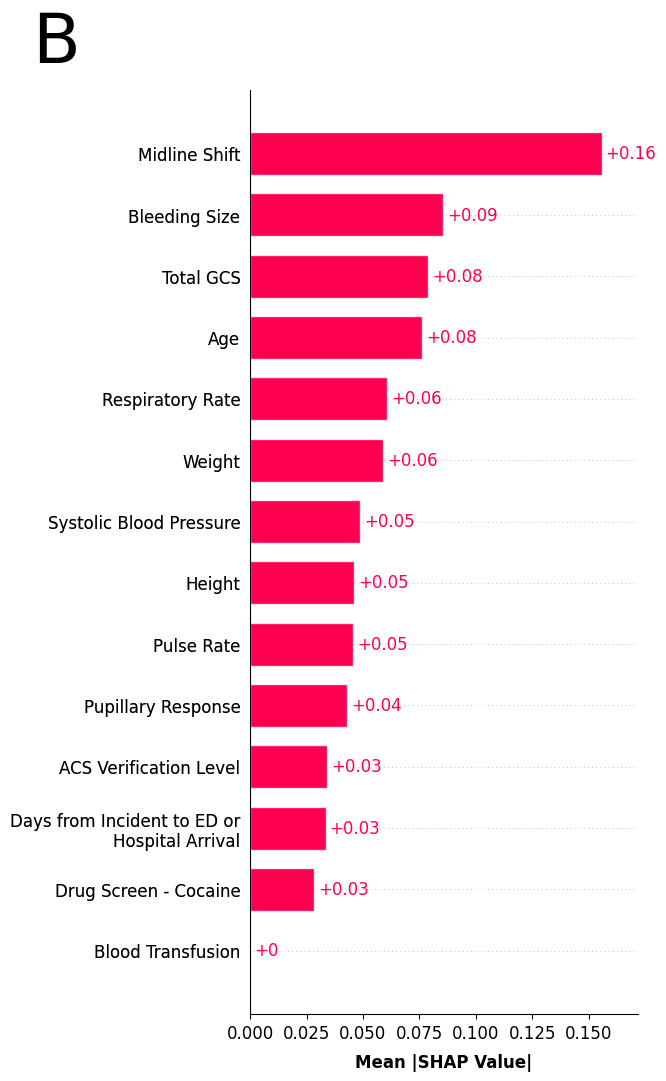

In [80]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_shap_xgb.png', dpi=300, bbox_inches='tight')

In [81]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test_sample)
lgb_shap_values = lgb_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


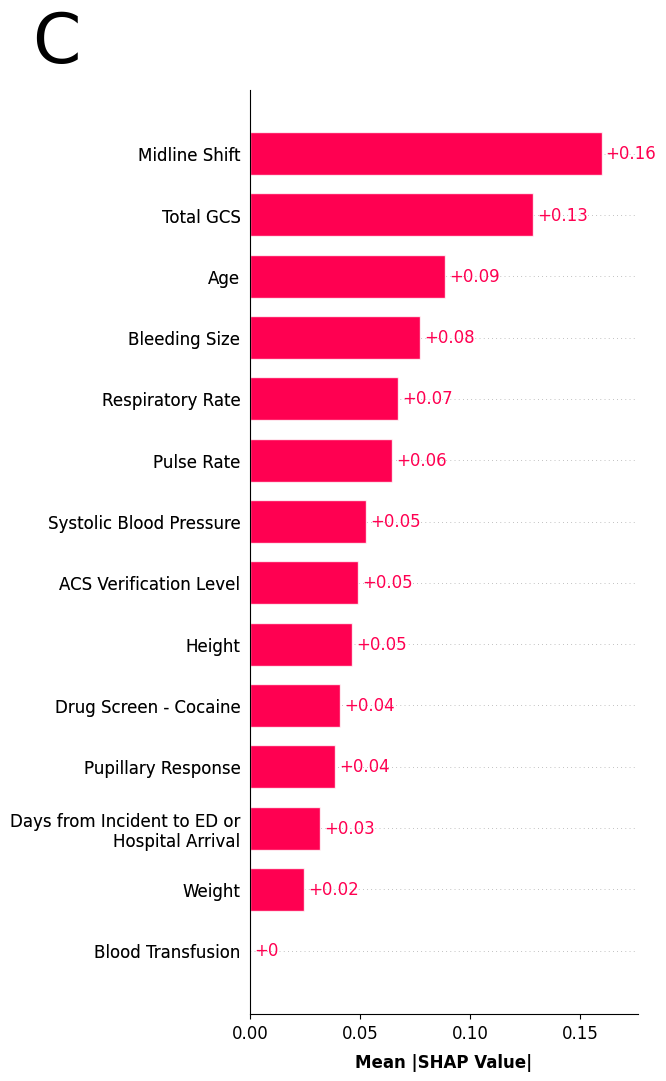

In [82]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_shap_lgb.png', dpi=300, bbox_inches='tight')

In [83]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test_sample)
rf_shap_values = rf_explainer(x_test_sample)

Streaming output truncated to the last 5000 lines.
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify a

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


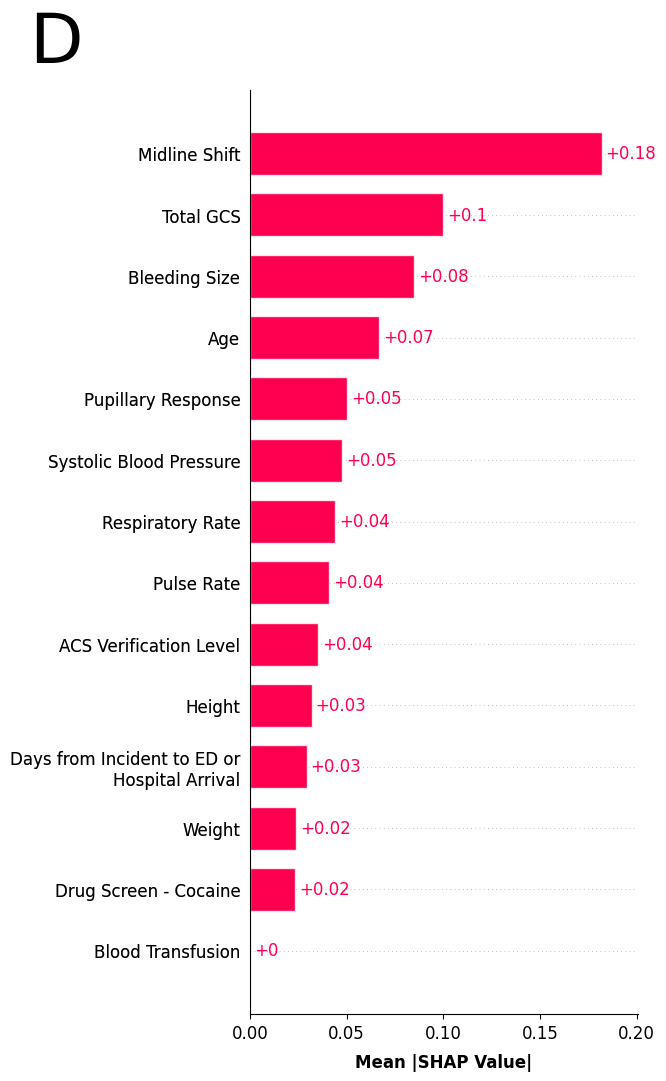

In [84]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('D', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_shap_rf.png', dpi=300, bbox_inches='tight')

#Partial Dependency Plots

In [85]:
pyplot.rcParams["figure.figsize"] = (15, 25)
pyplot.rcParams["figure.dpi"] = 300
pyplot.rcParams['axes.labelweight'] = 'bold'
pyplot.rcParams['axes.labelsize'] = 12
pyplot.rcParams['axes.labelpad'] = 6
pyplot.rcParams['font.weight'] = 'normal'
pyplot.rcParams['lines.linewidth'] = 2.5
pyplot.rcParams['xtick.labelsize'] = 8
pyplot.rcParams['ytick.labelsize'] = 8

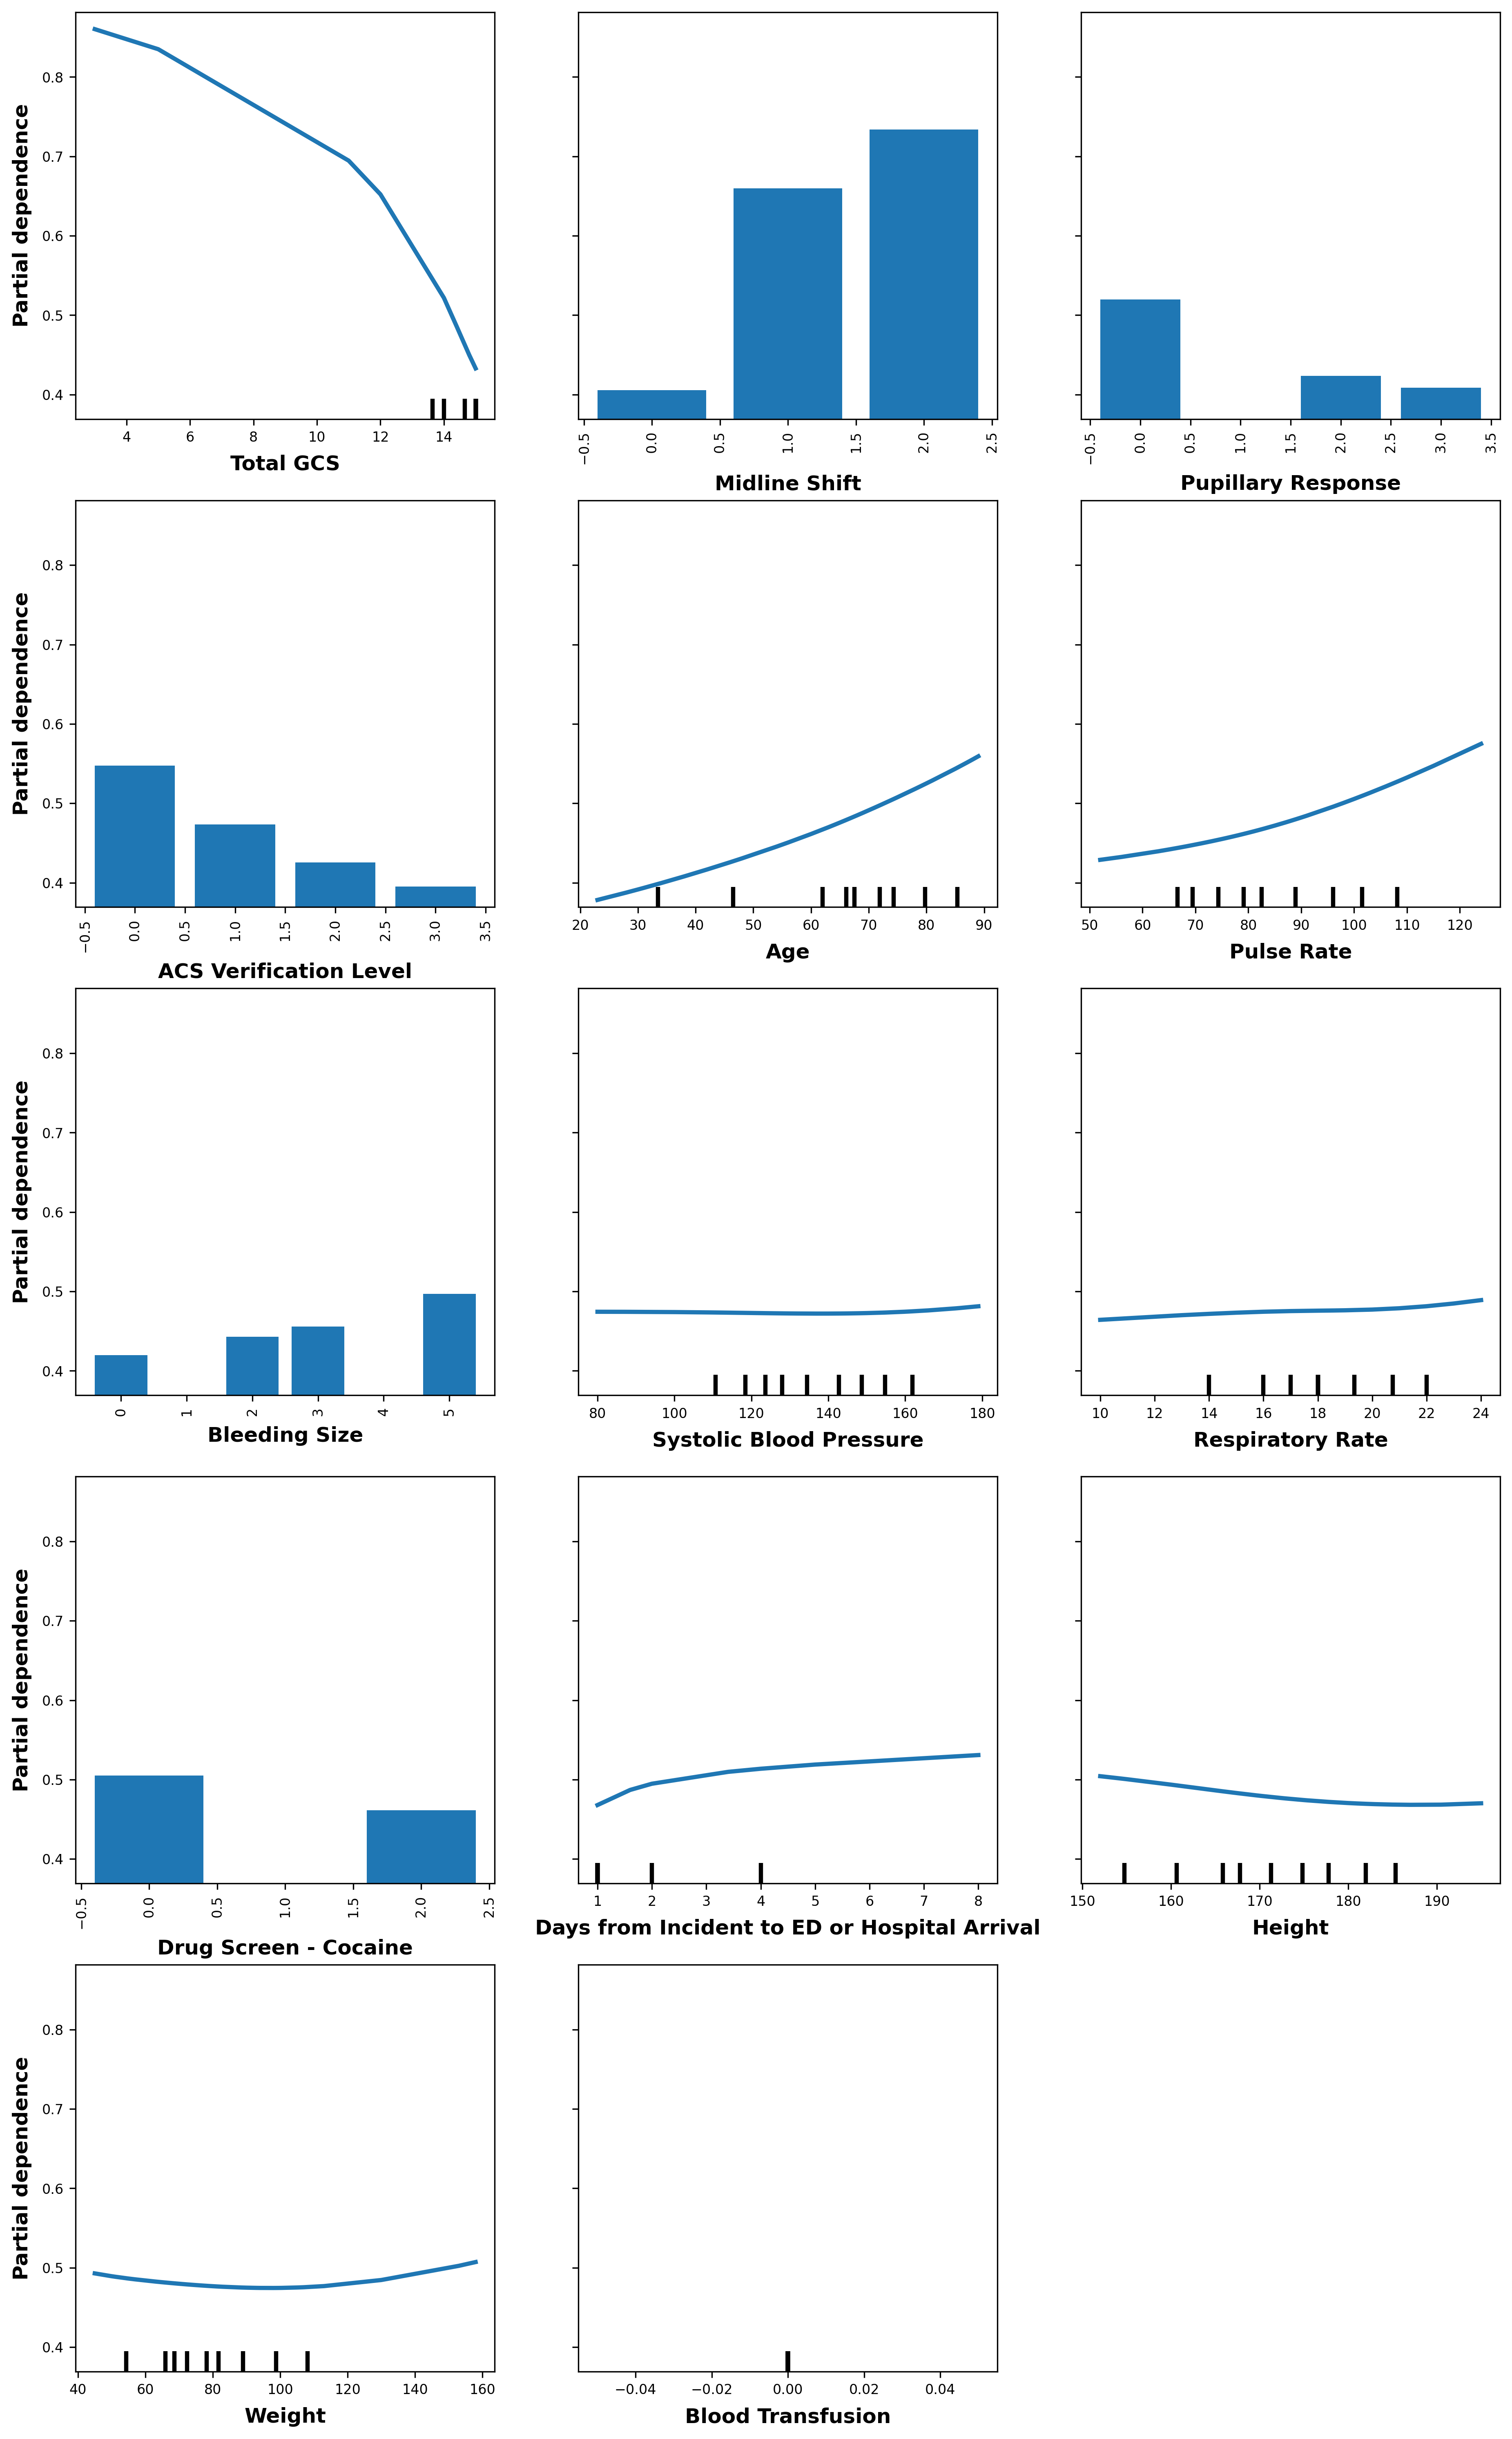

In [86]:
#Calculate the mean absolute SHAP values for each feature.
tabpfn_mean_abs_shap_values = np.mean(np.abs(tabpfn_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabpfn_shap_summary = pd.DataFrame(list(zip(feature_names, tabpfn_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabpfn_shap_summary_sorted = tabpfn_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabpfn_features = tabpfn_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(tabpfn, x_test_sample, tabpfn_features, categorical_features = ['Pupillary Response', 'Midline Shift', 'Bleeding Size', 'Drug Screen - Cocaine', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_pdp_tabpfn.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


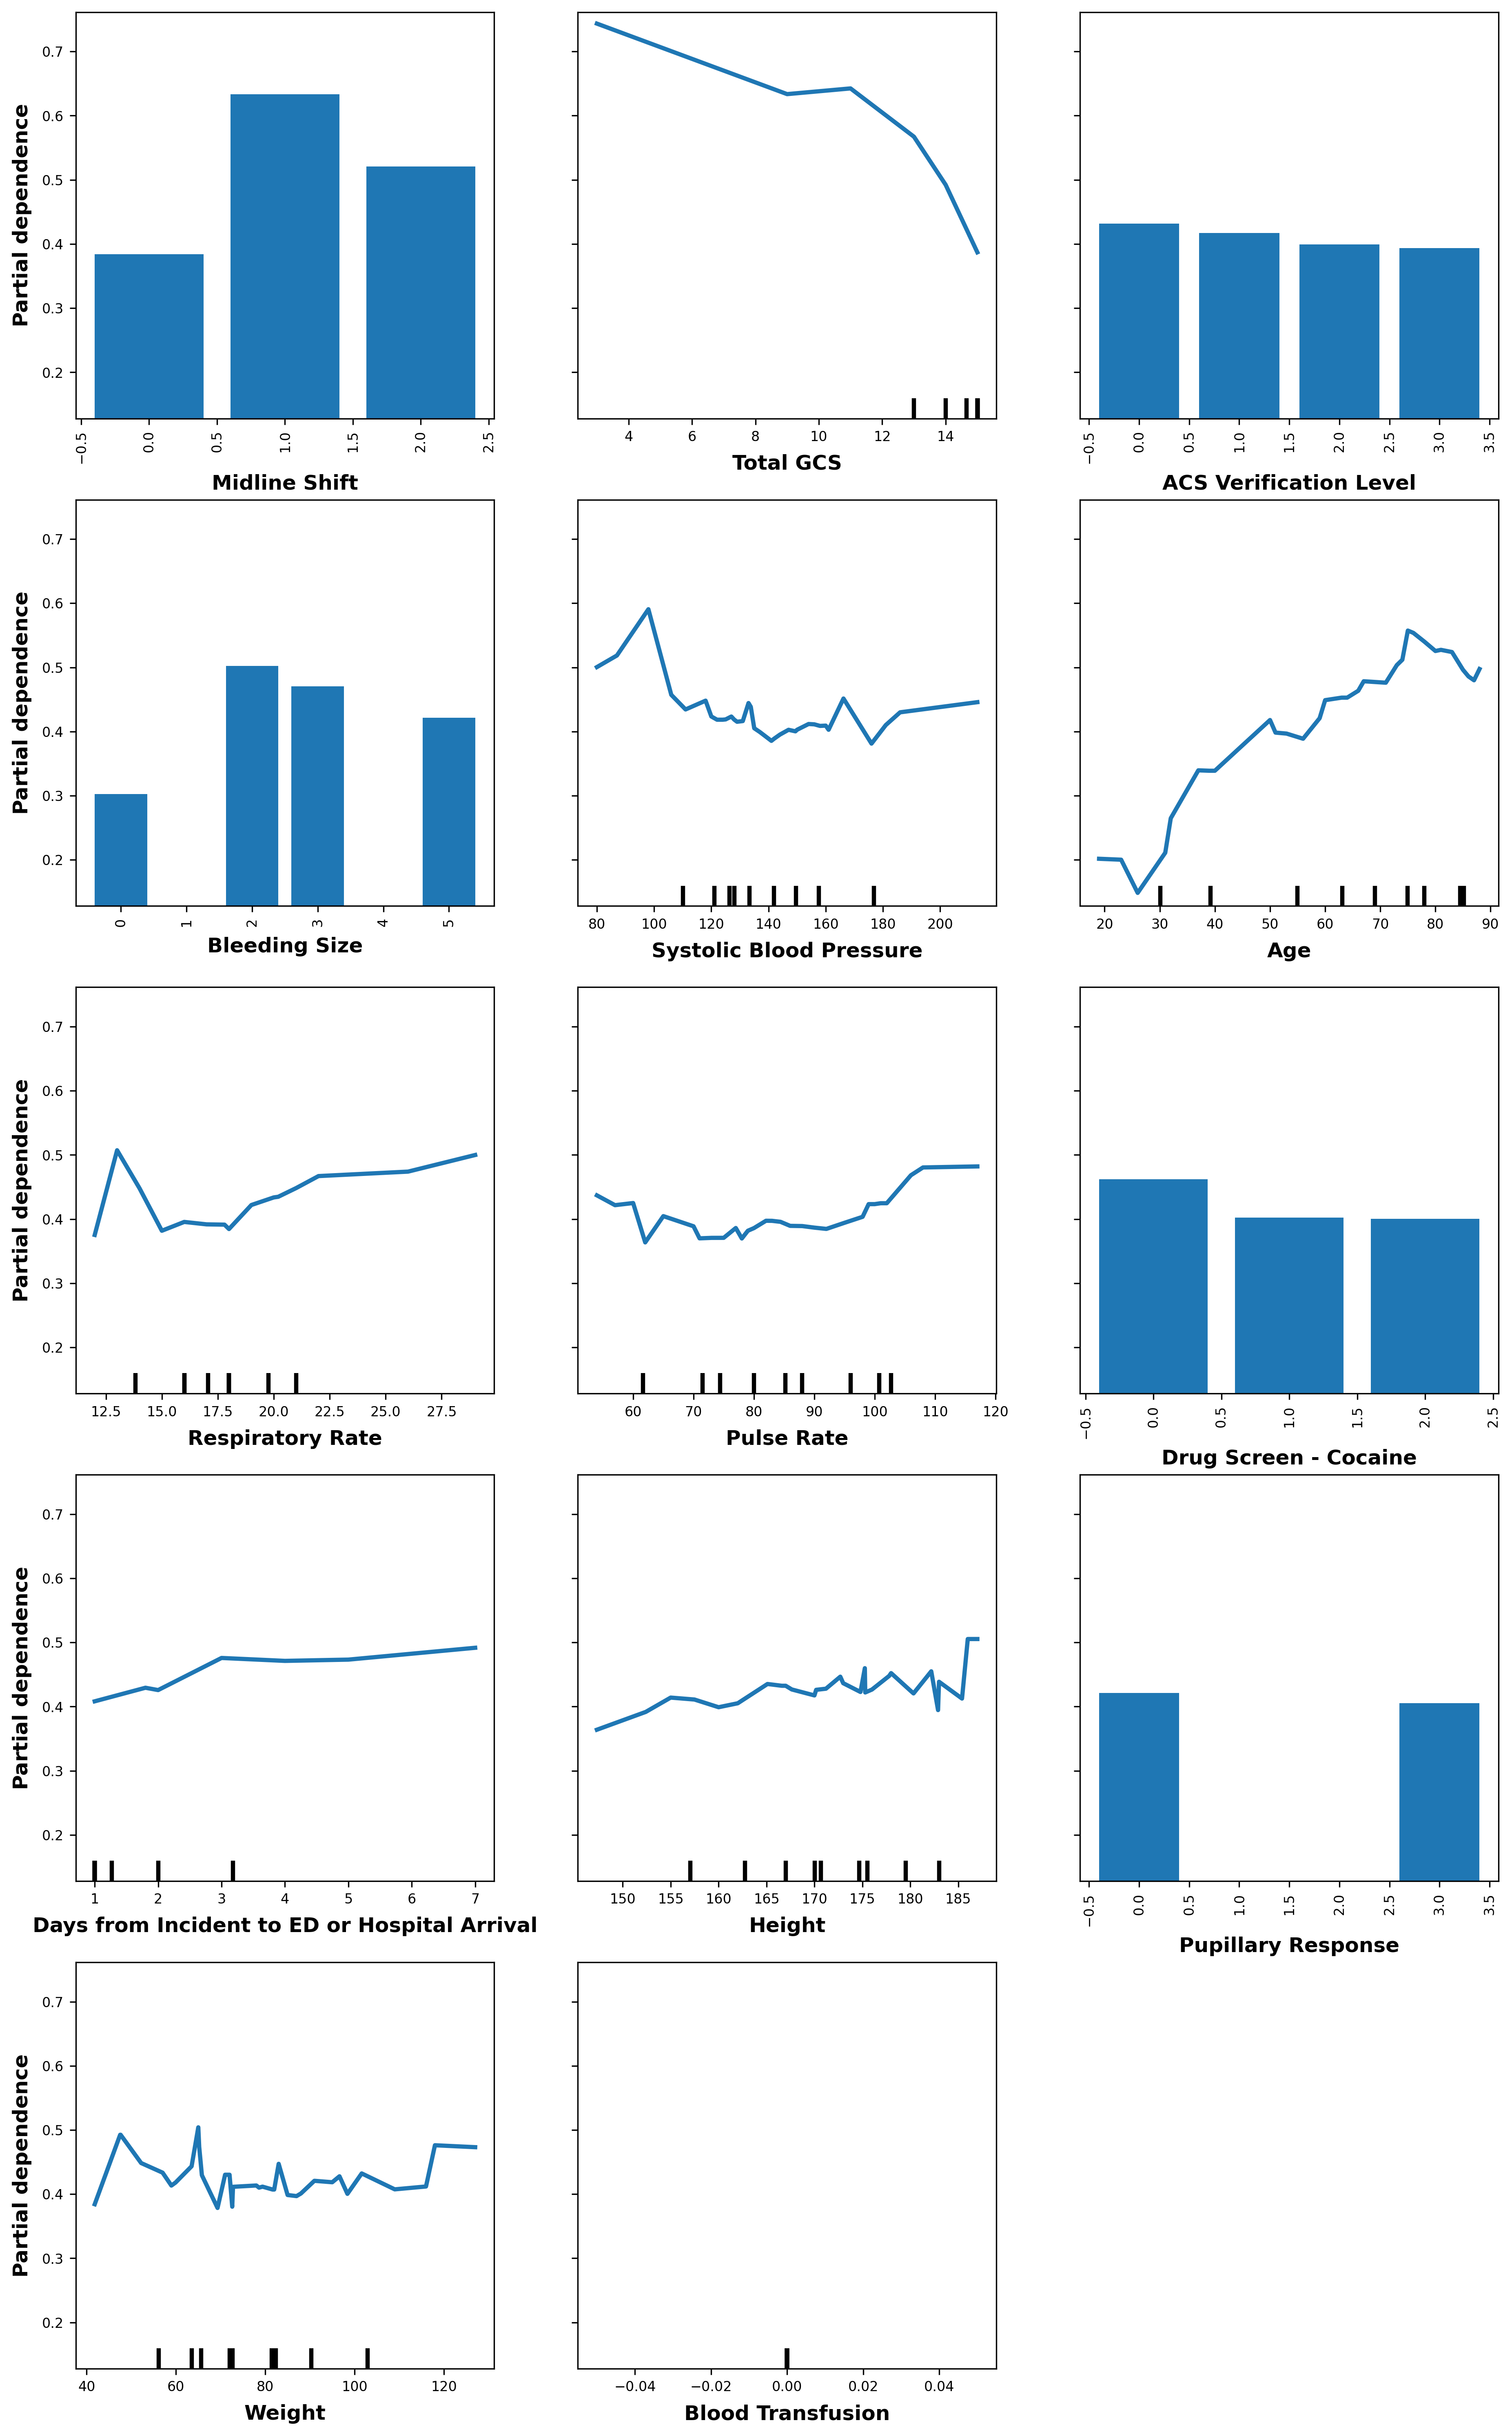

In [87]:
#Calculate the mean absolute SHAP values for each feature.
tabnet_mean_abs_shap_values = np.mean(np.abs(tabnet_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
tabnet_shap_summary = pd.DataFrame(list(zip(feature_names, tabnet_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
tabnet_shap_summary_sorted = tabnet_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
tabnet_features = tabnet_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, tabnet_x_test_sample, tabnet_features, categorical_features = ['Pupillary Response', 'Midline Shift', 'Bleeding Size', 'Drug Screen - Cocaine', 'ACS Verification Level'])

pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_pdp_tabnet.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


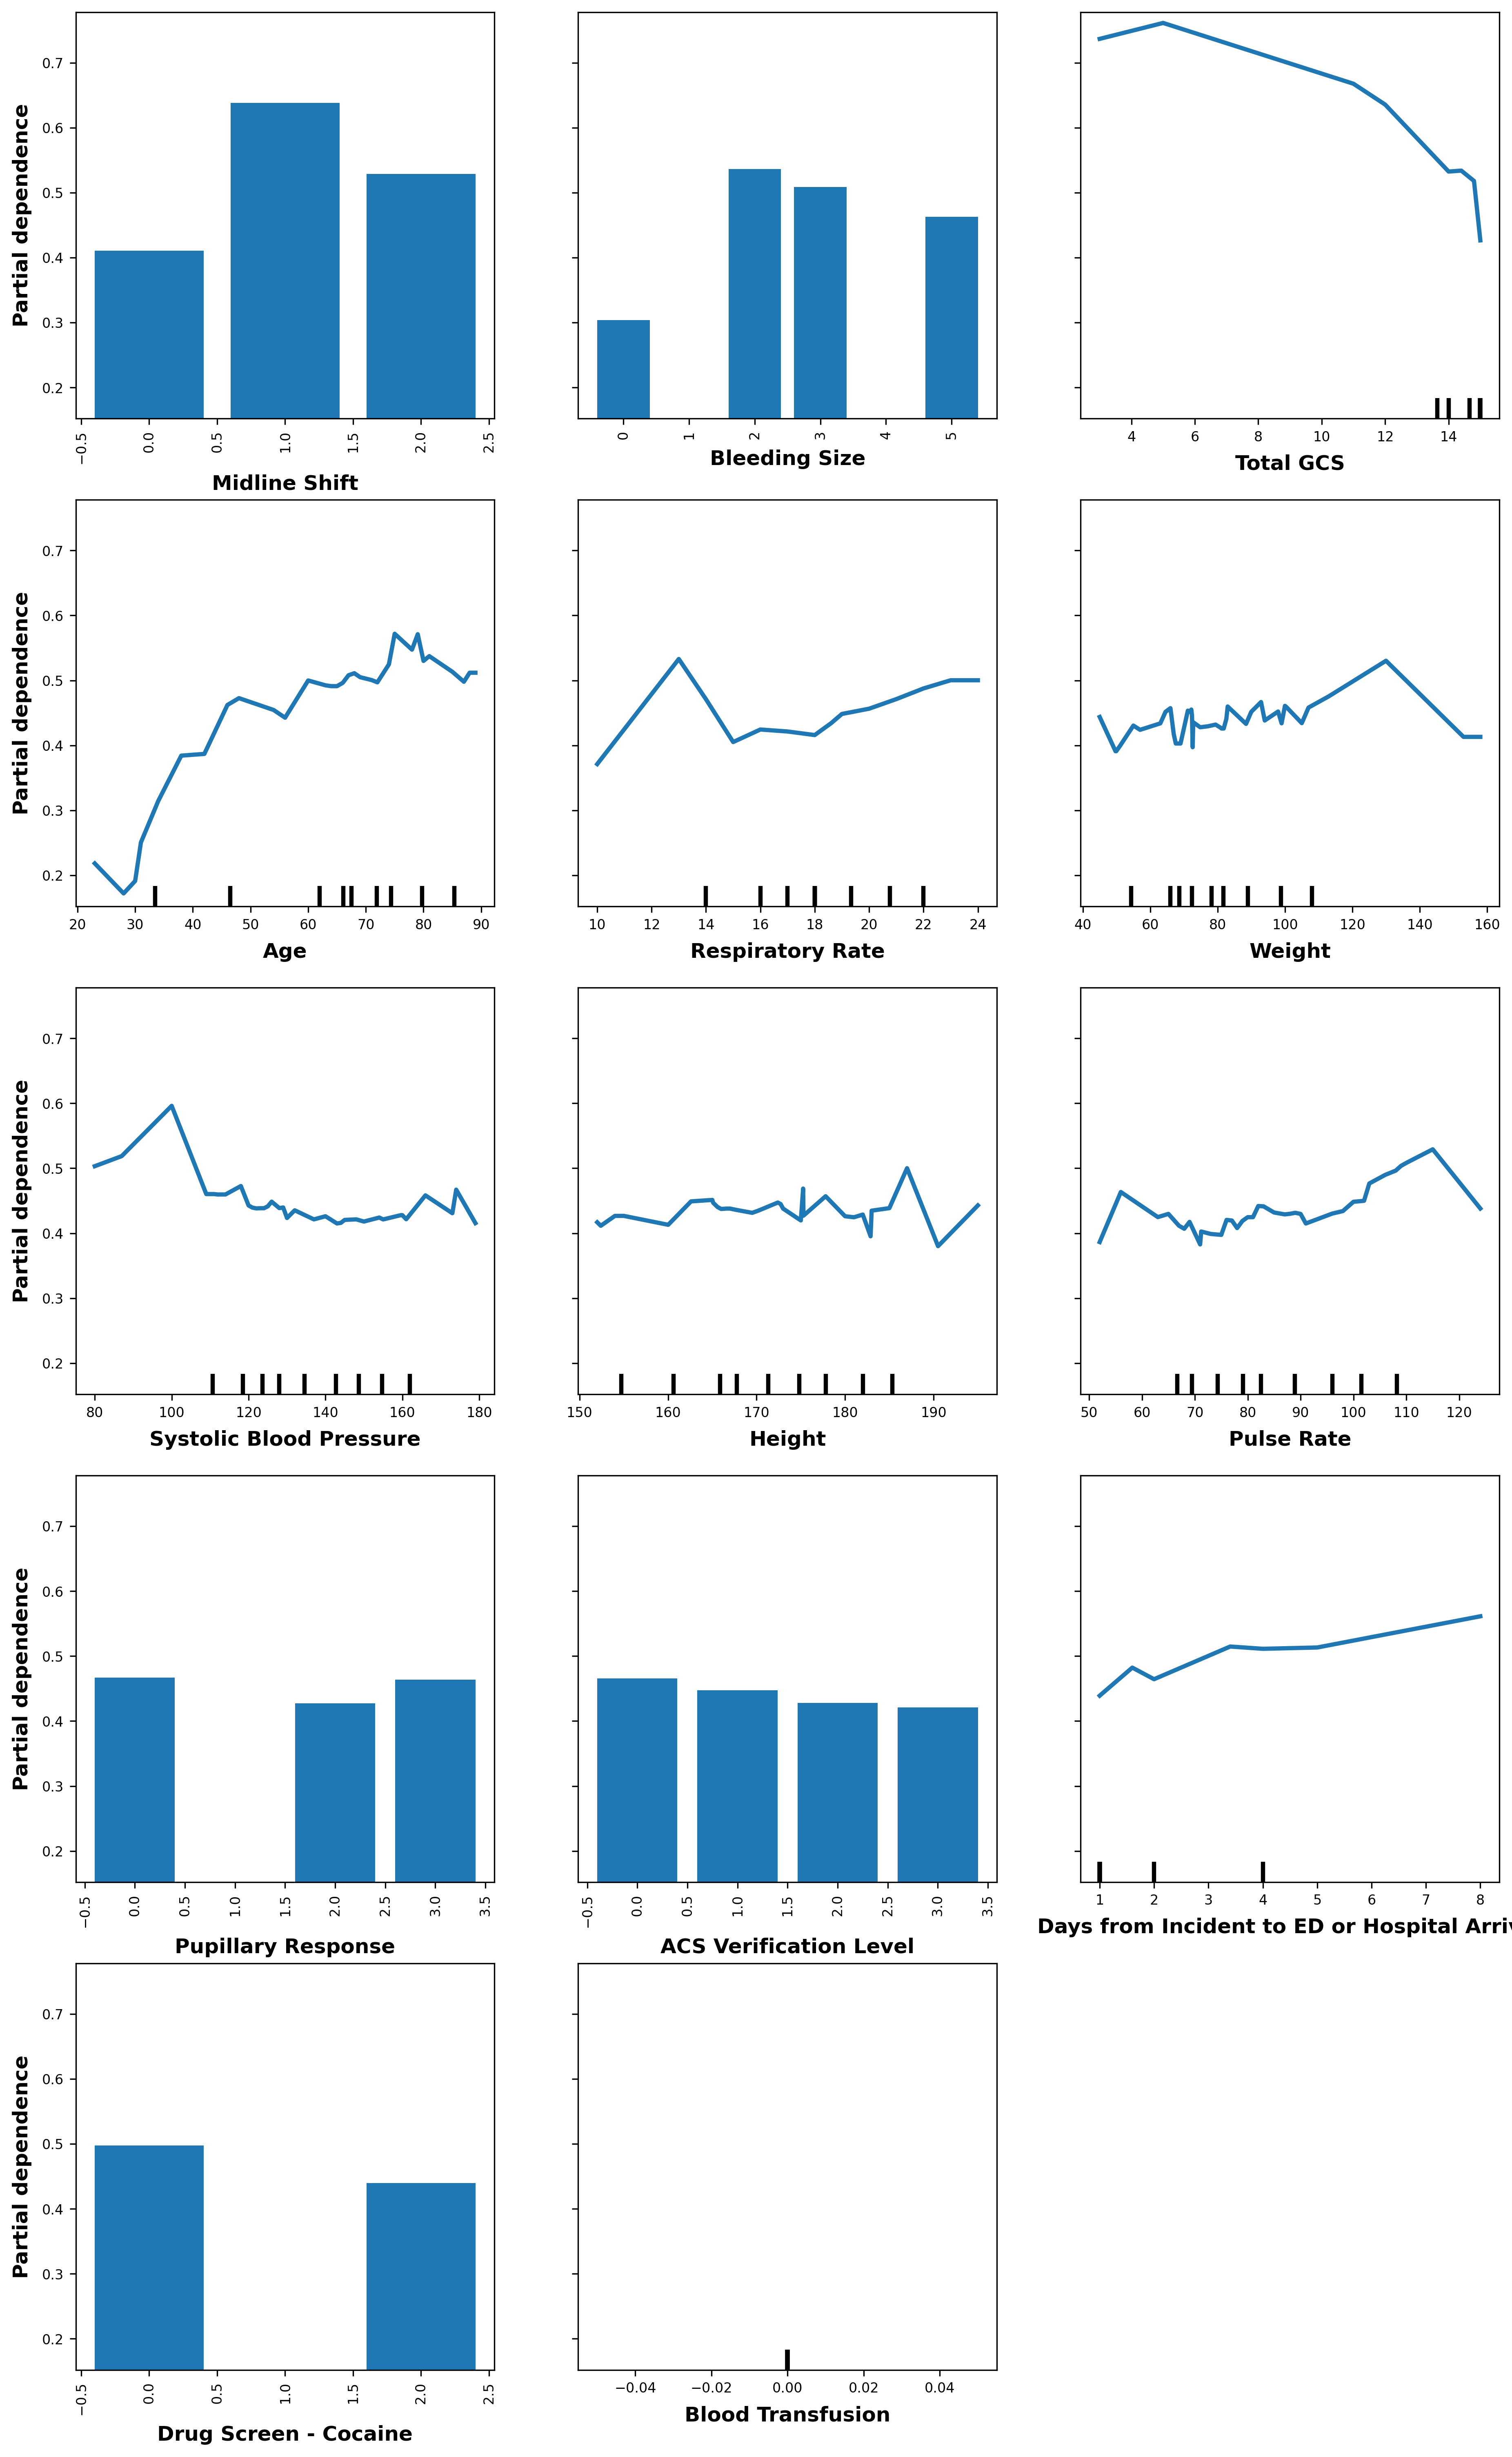

In [88]:
#Calculate the mean absolute SHAP values for each feature.
xgb_mean_abs_shap_values = np.mean(np.abs(xgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
xgb_shap_summary = pd.DataFrame(list(zip(feature_names, xgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
xgb_shap_summary_sorted = xgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
xgb_features = xgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(xgb, x_test_sample, xgb_features, categorical_features = ['Pupillary Response', 'Midline Shift', 'Bleeding Size', 'Drug Screen - Cocaine', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_pdp_xgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


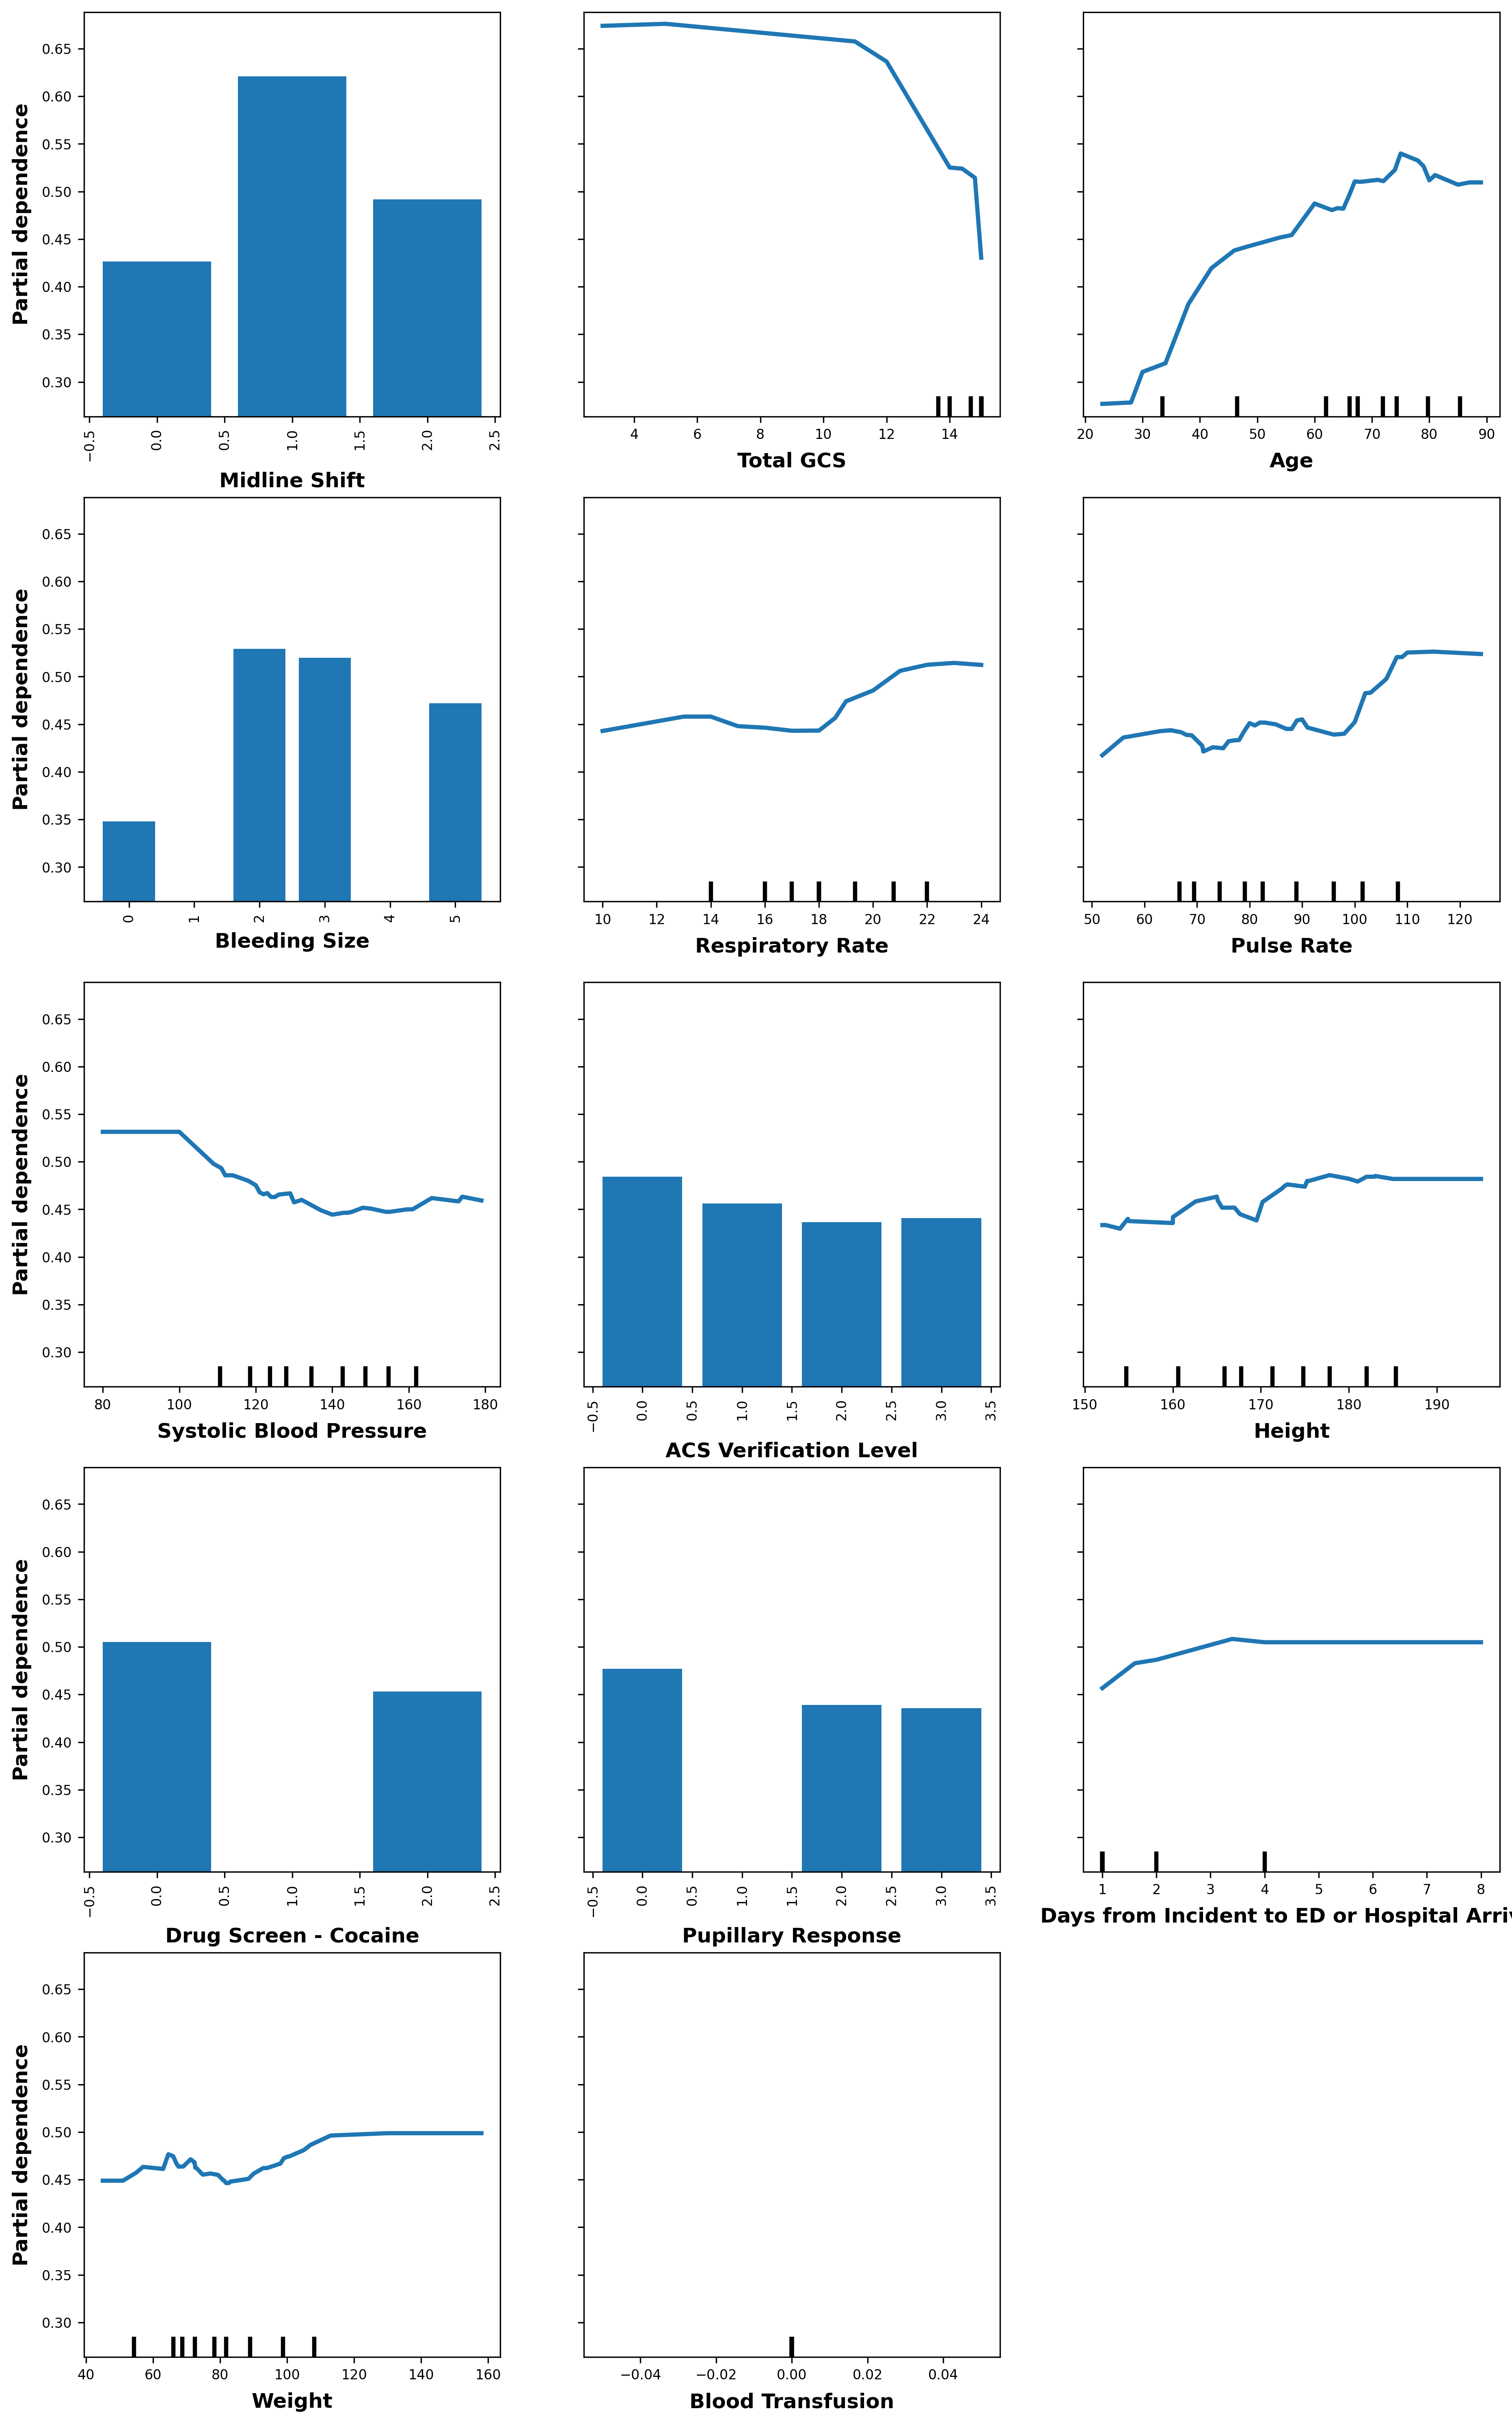

In [89]:
#Calculate the mean absolute SHAP values for each feature.
lgb_mean_abs_shap_values = np.mean(np.abs(lgb_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
lgb_shap_summary = pd.DataFrame(list(zip(feature_names, lgb_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
lgb_shap_summary_sorted = lgb_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
lgb_features = lgb_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(lgb, x_test_sample, lgb_features, categorical_features = ['Pupillary Response', 'Midline Shift', 'Bleeding Size', 'Drug Screen - Cocaine', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_pdp_lgb.png', dpi=300, bbox_inches='tight')
pyplot.show()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


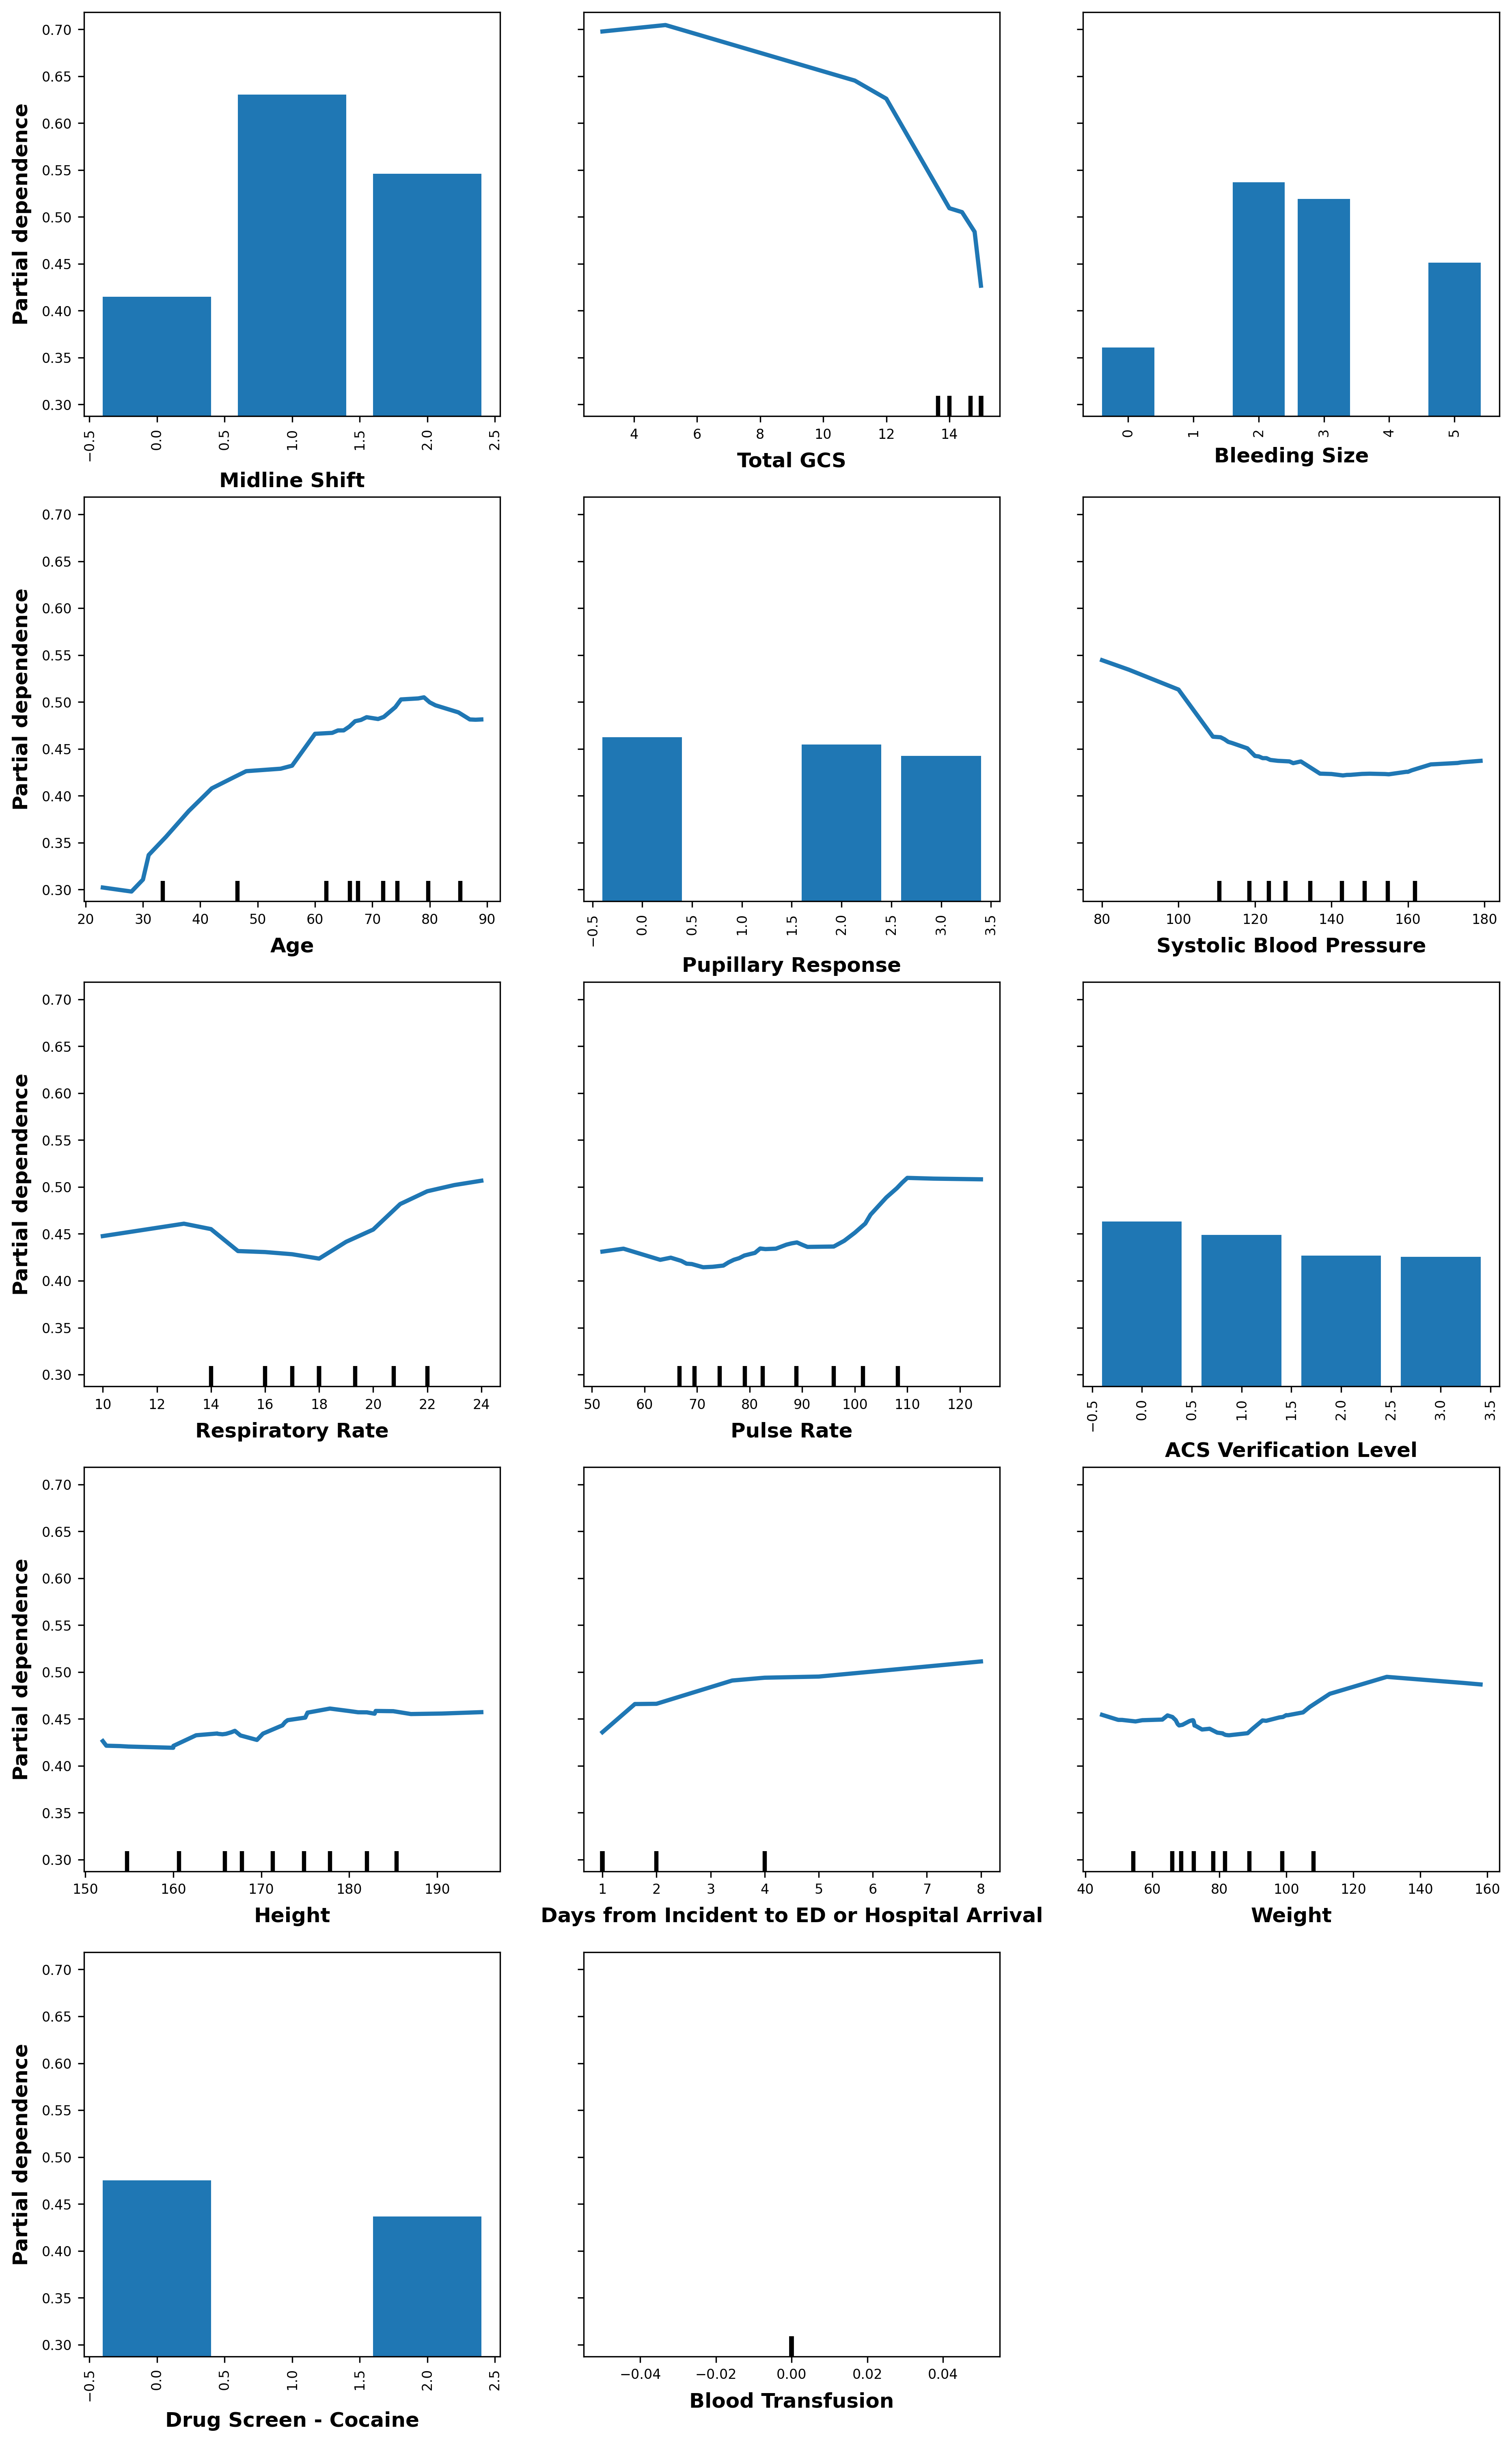

In [90]:
#Calculate the mean absolute SHAP values for each feature.
rf_mean_abs_shap_values = np.mean(np.abs(rf_shap_values.values), axis=0)

#Create a DataFrame to map feature names to their mean absolute SHAP values.
rf_shap_summary = pd.DataFrame(list(zip(feature_names, rf_mean_abs_shap_values)), columns=['Feature', 'Mean SHAP'])

#Sort the DataFrame by 'Mean SHAP' in descending order.
rf_shap_summary_sorted = rf_shap_summary.sort_values('Mean SHAP', ascending=False)

#Get the names of the features.
rf_features = rf_shap_summary_sorted['Feature'].tolist()

PartialDependenceDisplay.from_estimator(rf, x_test_sample, rf_features, categorical_features = ['Pupillary Response', 'Midline Shift', 'Bleeding Size', 'Drug Screen - Cocaine', 'ACS Verification Level'])
pyplot.savefig('/content/drive/MyDrive/TQP-atSDH/complications_pdp_rf.png', dpi=300, bbox_inches='tight')
pyplot.show()